## Setup

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [3]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [4]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    transform!(
        data,
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names
    )
    return nothing
end

separate_etaks! (generic function with 1 method)

In [5]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [6]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## Ground State Runs

In [96]:
results = JobResult("../jobs", "stripe")
separate_etaks!(results.data)
results

JobResult("../jobs", "stripe", 9×32 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.023077±7.3e-5     0.01  Complex{Measurement{Float64}}[0.…  0.00053241 ⋯
   2 │ 0.02297±0.00013     0.25  Complex{Measurement{Float64}}[0.…  0.00054412
   3 │ 0.02294±0.00016     0.5   Complex{Measurement{Float64}}[0.…  0.00054452
   4 │ 0.02312±0.0001      0.75  Complex{Measurement{Float64}}[0.…  0.00054439
   5 │ 0.023055±9.9e-5     1.0   Complex{Measurement{Float64}}[0.…  0.00055±5. ⋯
   6 │ 0.02315±9.5e-5      1.25  Complex{Measurement{Float64}}[0.…  0.000407±2
   7 │ 0.02318±0.00015     1.5   Complex{Measurement{Float64}}[0.…  0.00033879
   8 │ 0.023167±9.0e-5     1.75  Complex{Measurement{Float64}}[0.…  0.00034064
   9 │ 0.02321±0.00014     2.0   Complex{Measurement{Float64}}[0.…  0.00034

In [88]:
results[[:_ll_sweep_time, :_ll_measure_time]]

9×2 DataFrame
 Row │ _ll_sweep_time     _ll_measure_time 
     │ Measurement…       Measurement…     
─────┼─────────────────────────────────────
   1 │ 0.00053241±8.5e-7  0.000217±2.4e-5
   2 │ 0.00054412±3.6e-7  0.0001673±4.9e-6
   3 │ 0.00054452±5.5e-7  0.0001796±8.9e-6
   4 │ 0.00054439±2.7e-7  0.0001645±2.7e-6
   5 │ 0.00055±5.9e-6     0.0001734±6.8e-6
   6 │ 0.000407±2.5e-5    0.000144±1.6e-5
   7 │ 0.00033879±6.9e-7  0.0001062±3.5e-6
   8 │ 0.00034064±8.6e-7  0.0001057±2.1e-6
   9 │ 0.0003474±2.9e-6   0.000129±1.6e-5

In [102]:
mctimes = get_mctime_data(results, :etak_corrs)
separate_etaks!.(mctimes)
mctimes

9-element Vector{DataFrame}:
 100×10 DataFrame
 Row │ etak_corrs                         ηk_xx                              η ⋯
     │ SubArray…                          Array…                             A ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[0.00107752+0.0im 0.00…  ComplexF64[0.00107752+0.0im 0.00…  C ⋯
   2 │ ComplexF64[0.00109027+0.0im 0.00…  ComplexF64[0.00109027+0.0im 0.00…  C
   3 │ ComplexF64[0.00102462+0.0im 0.00…  ComplexF64[0.00102462+0.0im 0.00…  C
   4 │ ComplexF64[0.000979656+0.0im 0.0…  ComplexF64[0.000979656+0.0im 0.0…  C
   5 │ ComplexF64[0.000983092+0.0im 0.0…  ComplexF64[0.000983092+0.0im 0.0…  C ⋯
   6 │ ComplexF64[0.000889827+0.0im 0.0…  ComplexF64[0.000889827+0.0im 0.0…  C
   7 │ ComplexF64[0.000982361+0.0im 0.0…  ComplexF64[0.000982361+0.0im 0.0…  C
   8 │ ComplexF64[0.000889037+0.0im 0.0…  ComplexF64[0.000889037+0.0im 0.0…  C
  ⋮  │                 ⋮                                  ⋮               

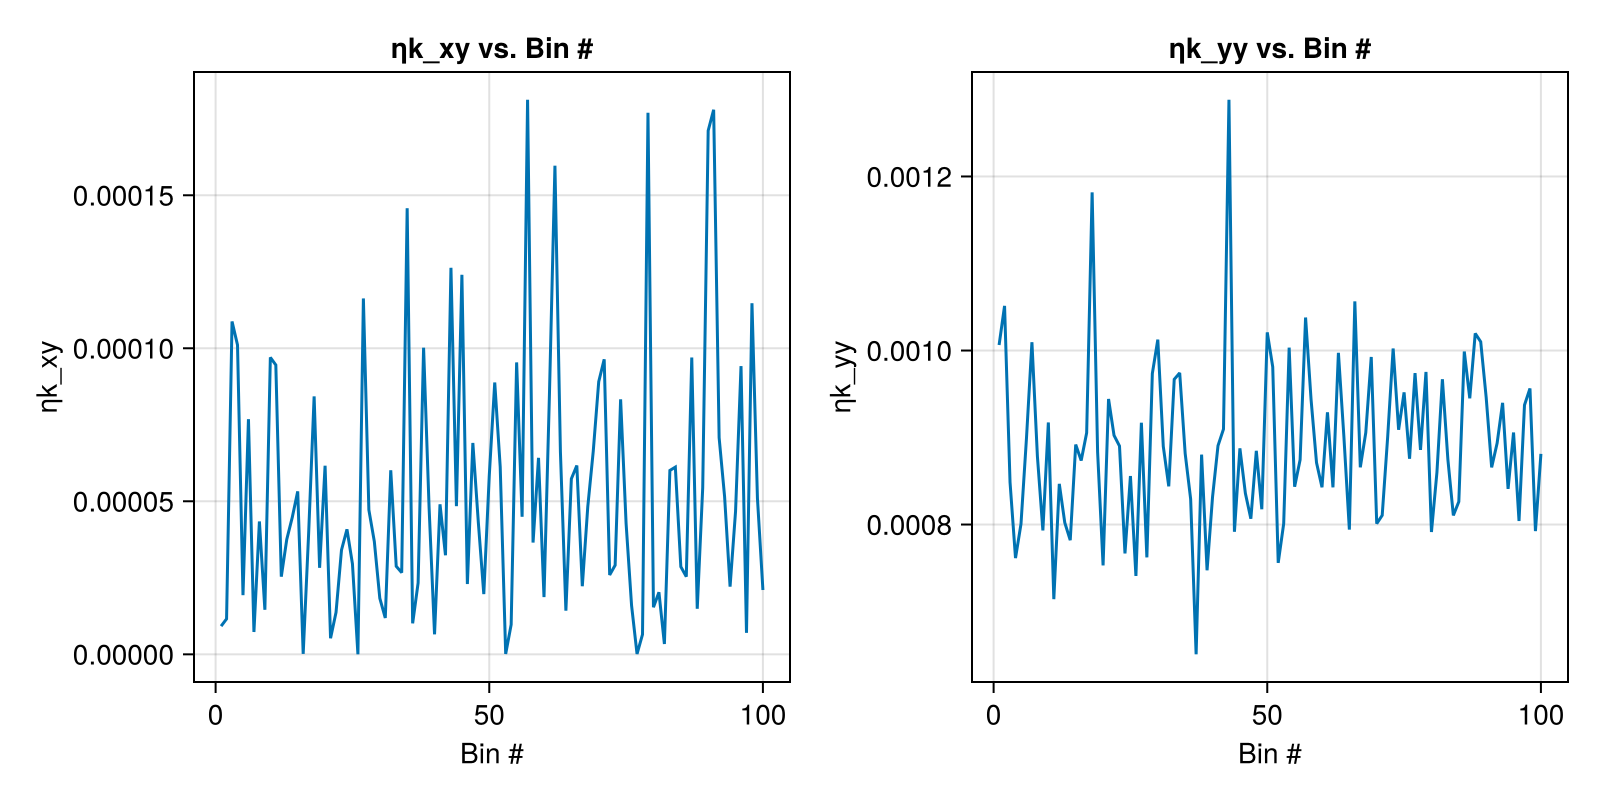

In [114]:
CairoMakie.activate!()
i = 8
k_pos = (1, 11)

var1 = :ηk_xy
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(mctimes[i][:, var2], k_pos...)))
fig

In [89]:
spink_corrs = results[:spink_corrs]

9-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.005193 ± 3.8e-5 0.005032 ± 1.8e-5 … 0.004548 ± 2.1e-5 0.005032 ± 1.8e-5; 0.005055 ± 3.9e-5 0.005003 ± 1.9e-5 … 0.004131 ± 1.7e-5 0.004681 ± 2.7e-5; … ; 0.004532 ± 2.5e-5 0.004118 ± 1.7e-5 … 0.004547 ± 1.7e-5 0.004712 ± 2.3e-5; 0.005055 ± 3.9e-5 0.004681 ± 2.7e-5 … 0.004685 ± 1.6e-5 0.005003 ± 1.9e-5]
 [0.005254 ± 3.7e-5 0.005017 ± 3.1e-5 … 0.004475 ± 1.9e-5 0.005017 ± 3.1e-5; 0.005005 ± 3.5e-5 0.005001 ± 3.6e-5 … 0.004133 ± 1.4e-5 0.004684 ± 3.5e-5; … ; 0.004567 ± 2.3e-5 0.004122 ± 2.0e-5 … 0.004509 ± 2.1e-5 0.004712 ± 3.1e-5; 0.005005 ± 3.5e-5 0.004684 ± 3.5e-5 … 0.004659 ± 1.5e-5 0.005001 ± 3.6e-5]
 [0.005175 ± 3.0e-5 0.005016 ± 2.8e-5 … 0.004495 ± 2.4e-5 0.005016 ± 2.8e-5; 0.00502 ± 2.1e-5 0.005003 ± 3.8e-5 … 0.004093 ± 2.3e-5 0.004657 ± 2.4e-5; … ; 0.004515 ± 3.4e-5 0.004127 ± 2.3e-5 … 0.004576 ± 2.3e-5 0.004708 ± 3.2e-5; 0.00502 ± 2.1e-5 0.004657 ± 2.4e-5 … 0.004674 ± 1.7e-5 0.005003 ± 3.8e-5]
 [0.005147 ± 2.8e-5 0.0

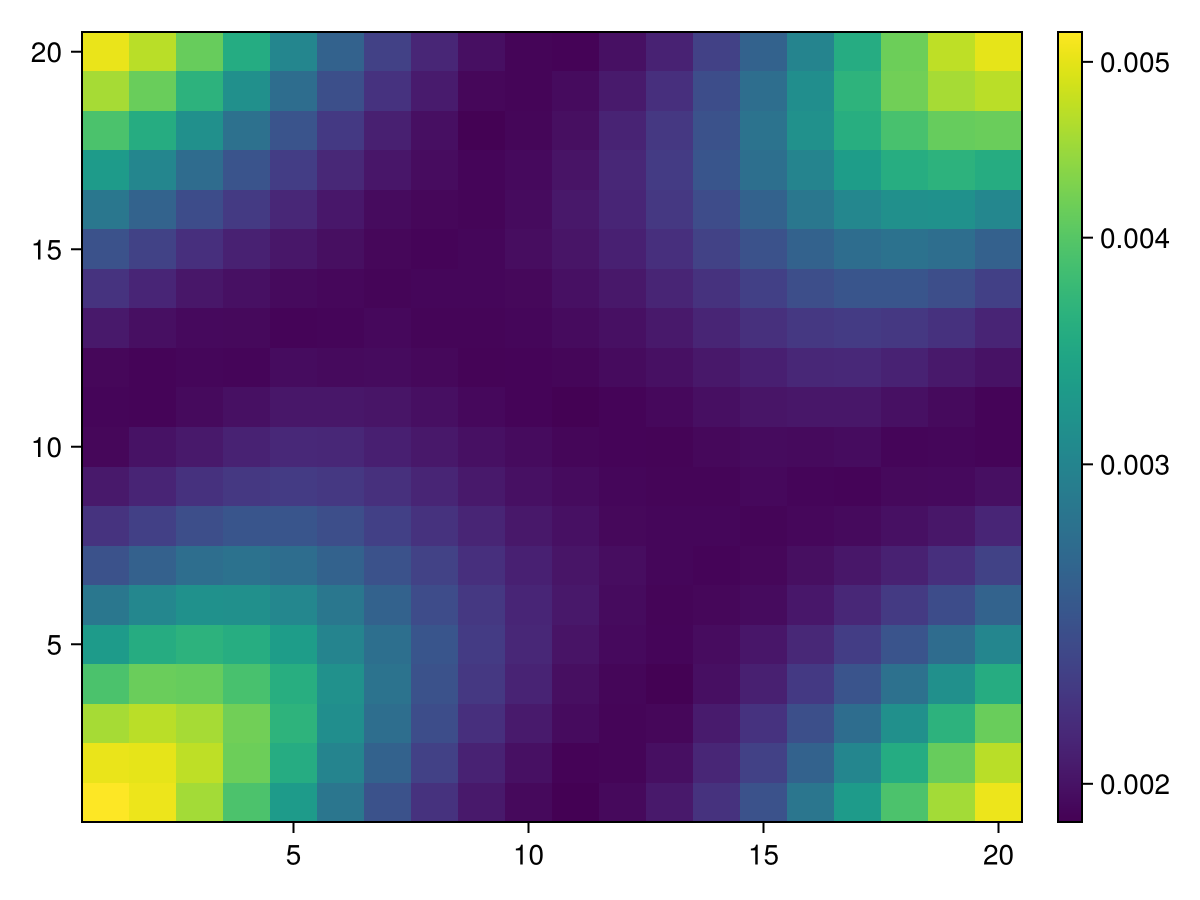

In [91]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Maximum correlation norm: 0.0009543 ± 6.0e-6

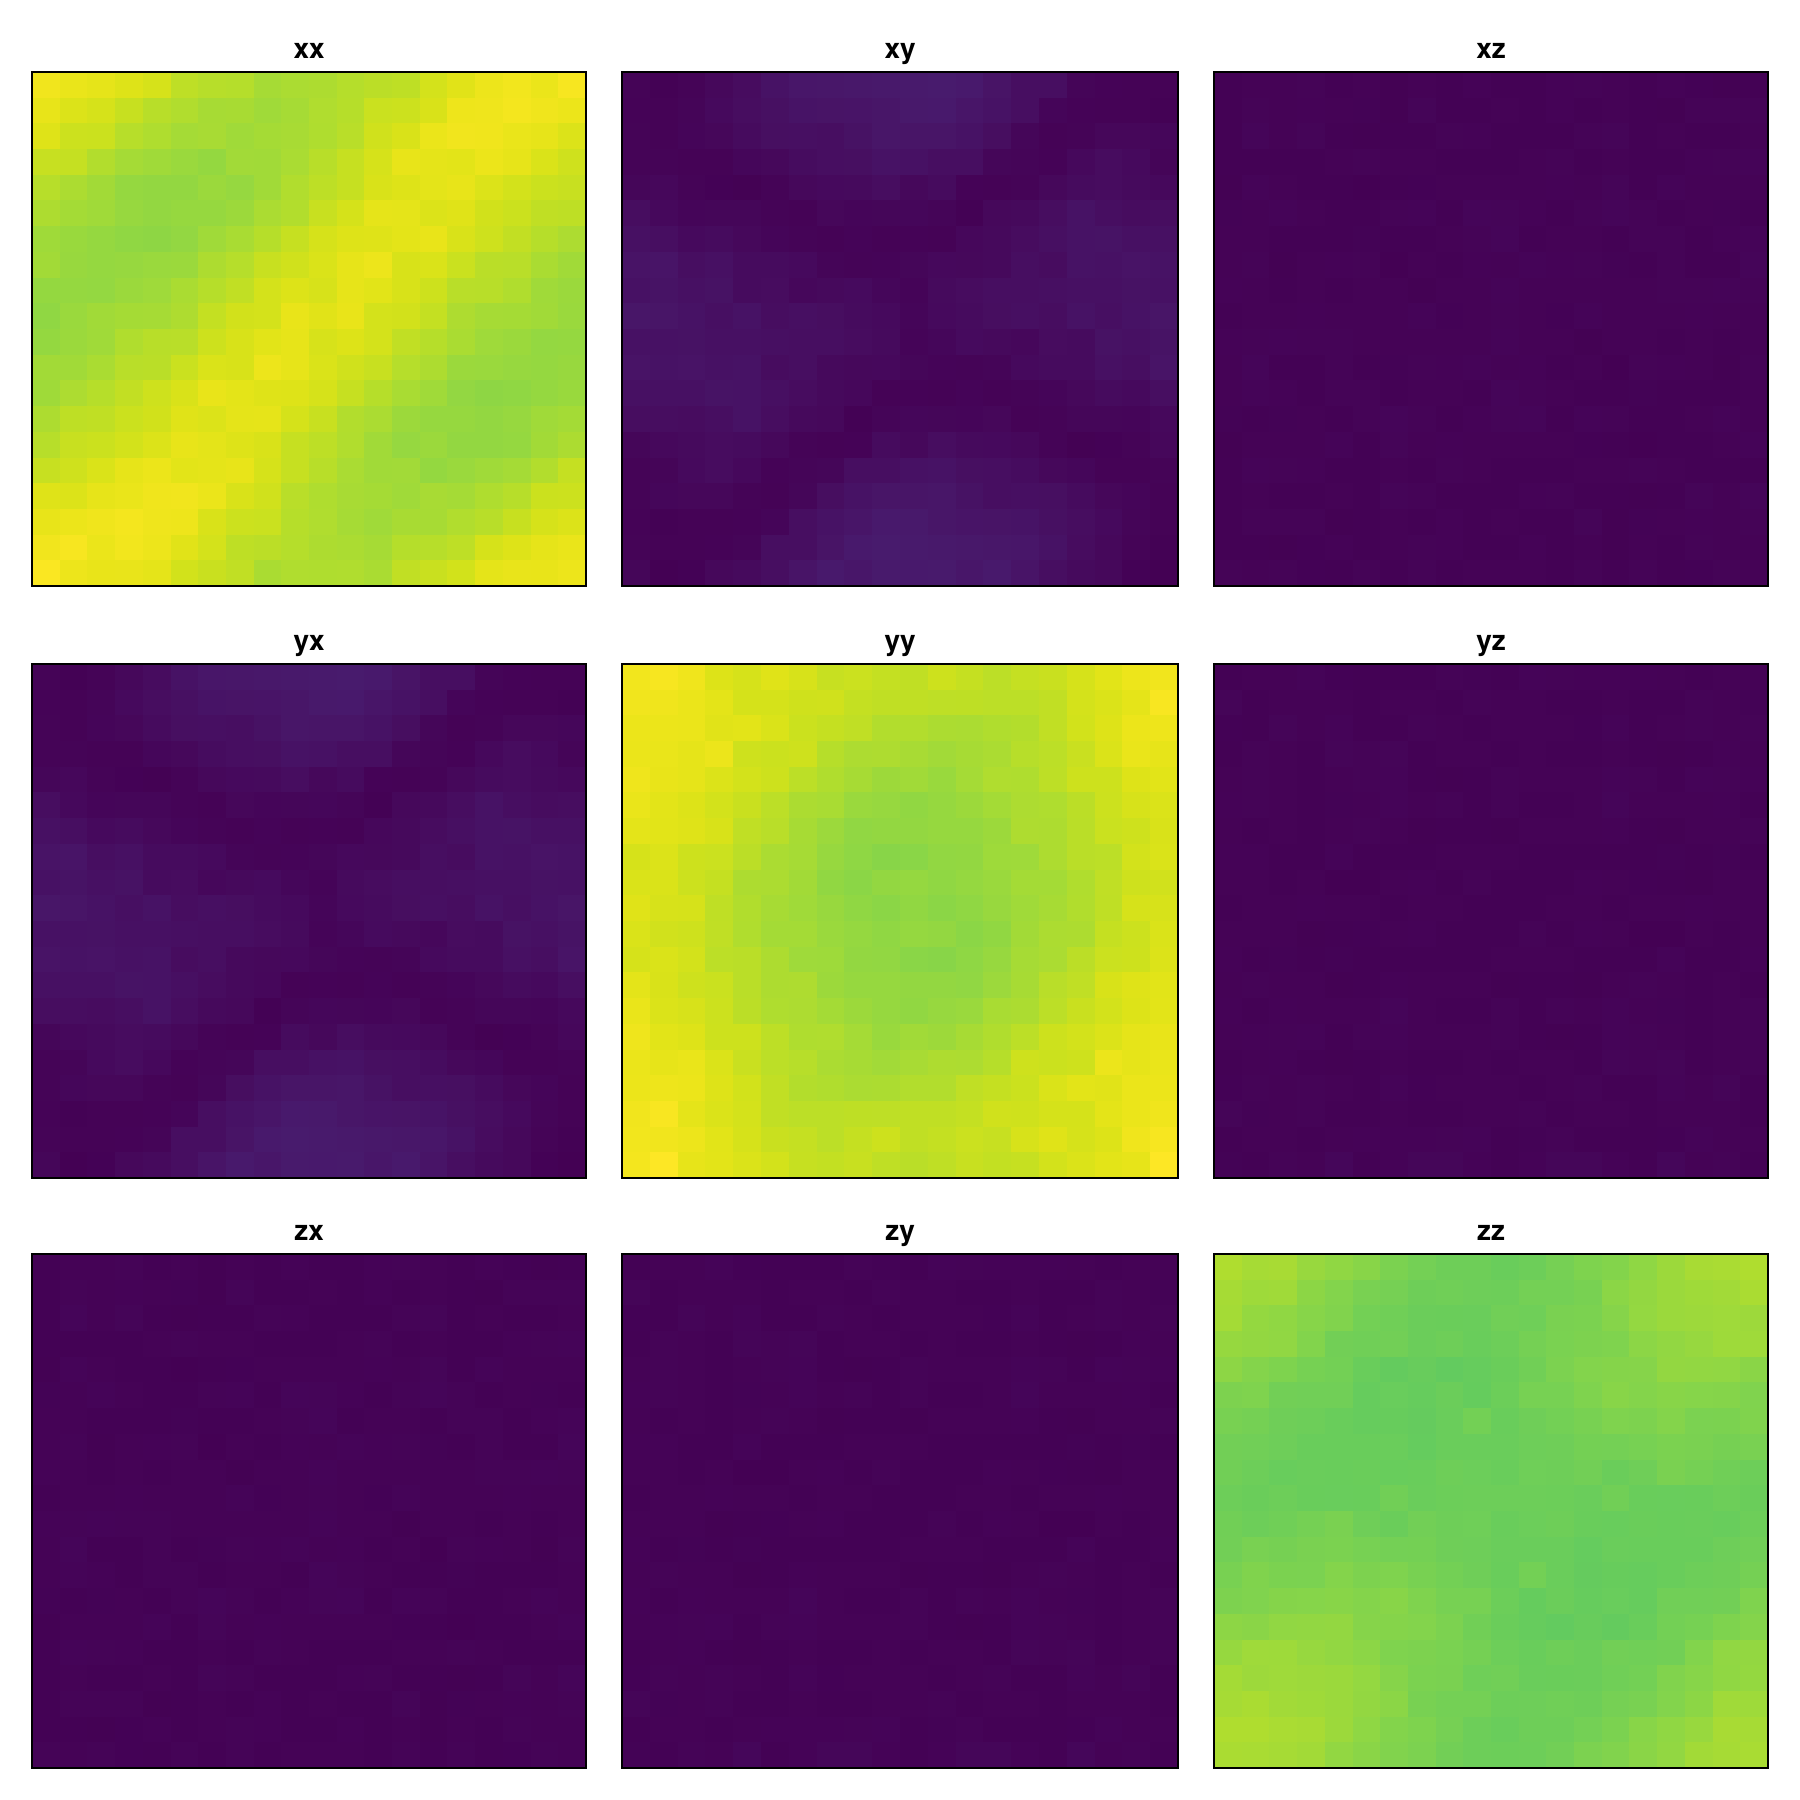

In [97]:
CairoMakie.activate!()
etak_corrs = results[:etak_corrs]

i = 1
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

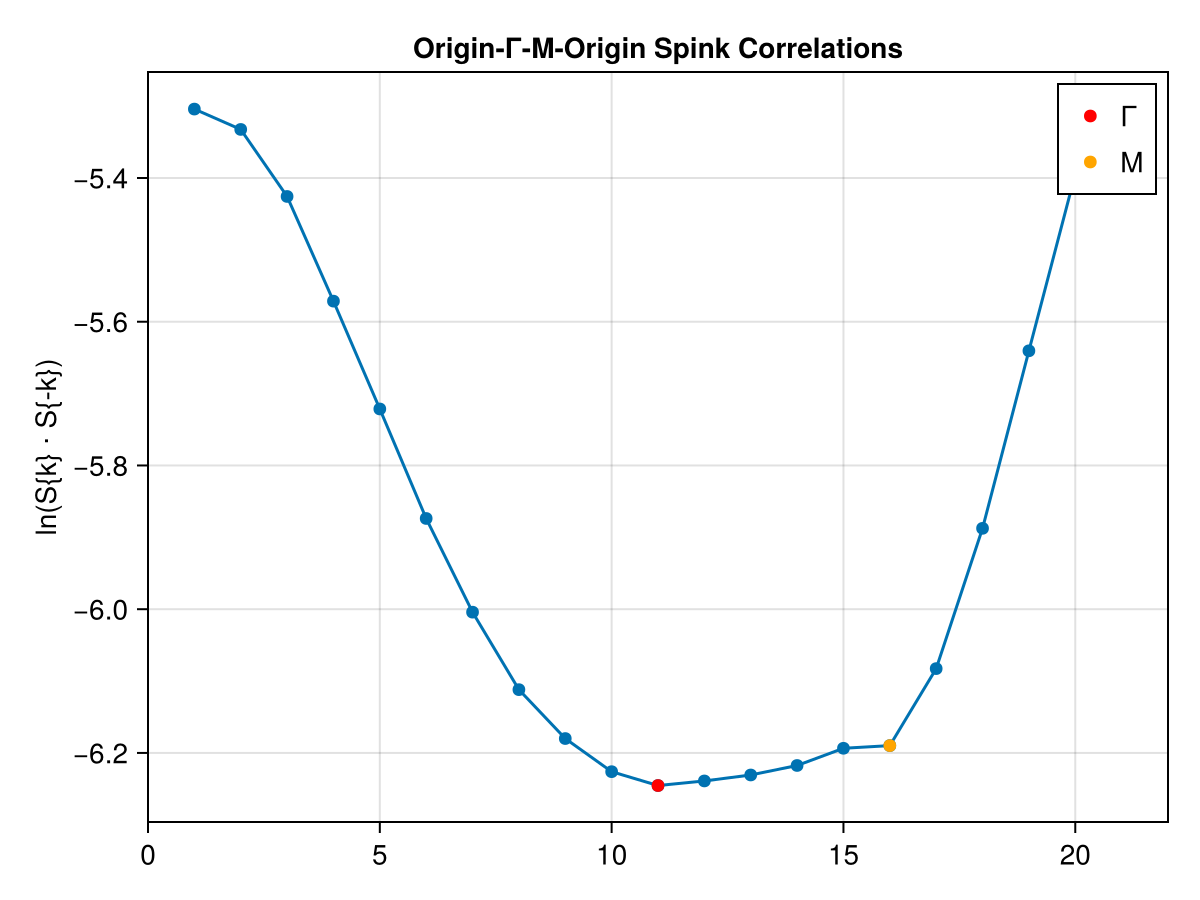

In [ ]:
CairoMakie.activate!()
task_no = 10
Lx, Ly = size(spink_corrs[task_no])

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
log_corrs = log.(corrs)
scatter!(ax, log_corrs)
errorbars!(ax, 1:length(path), getfield.(log_corrs, :val), getfield.(log_corrs, :err))
lines!(ax, log_corrs)
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

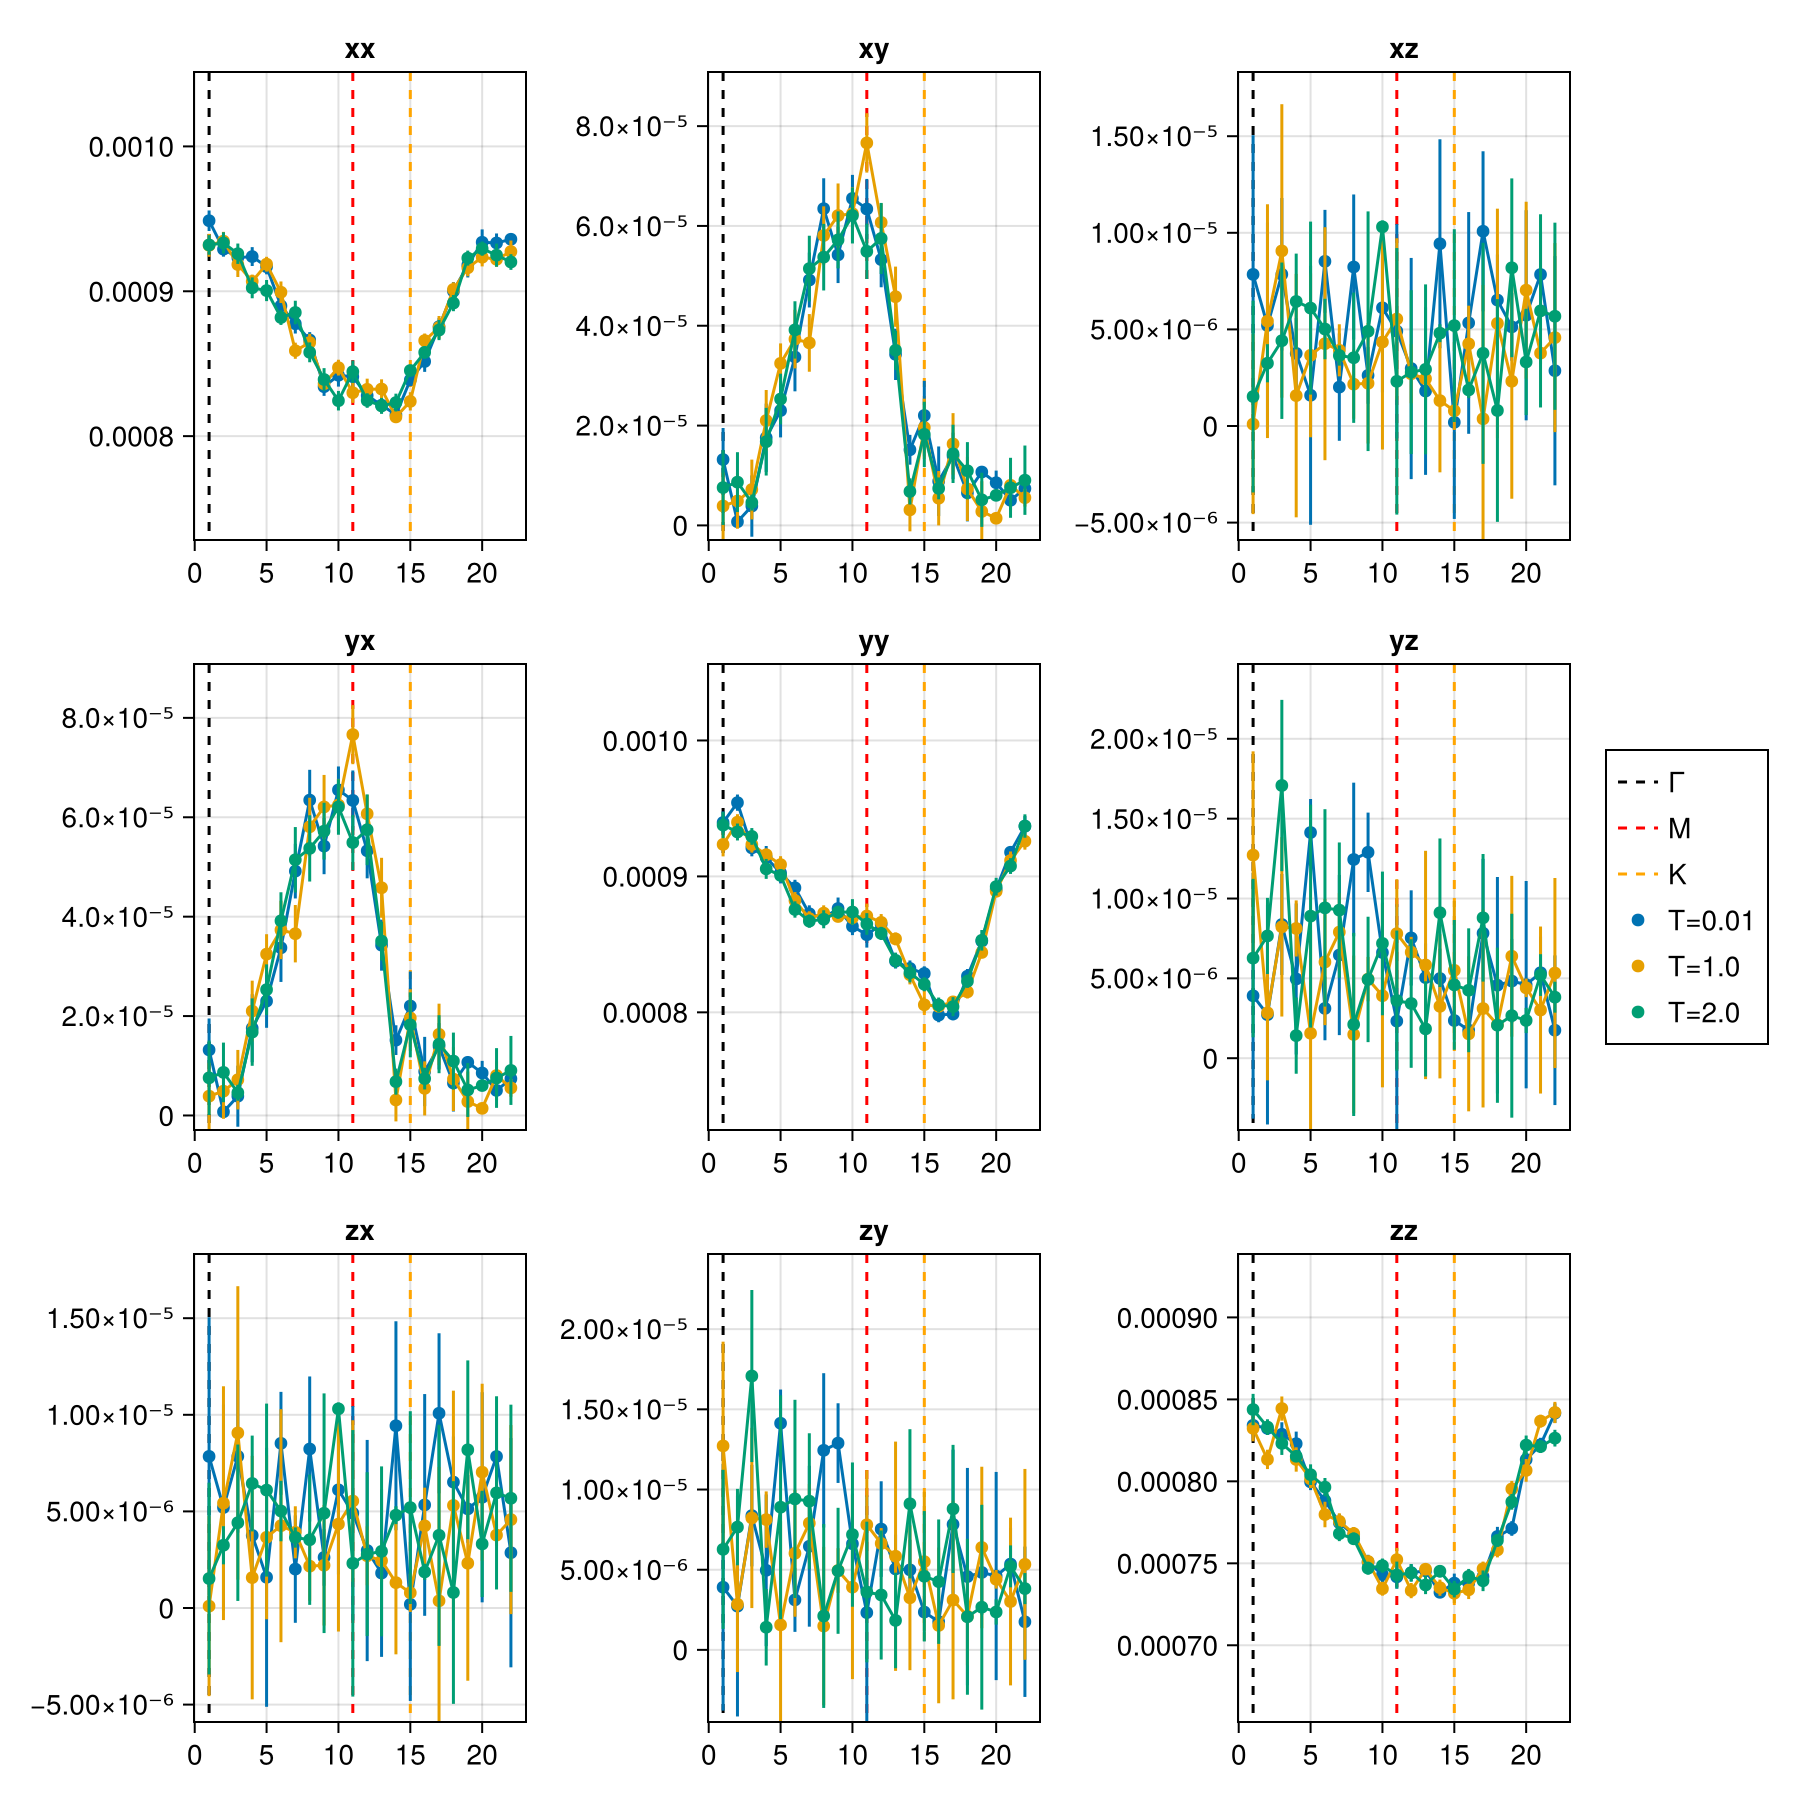

In [101]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 9]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## Annealed Runs

In [ ]:
results = JobResult("../jobs", "stripe-anneal")

JobResult("../jobs", "stripe-anneal", 10×23 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.02309±0.0001       0.5     10.0  Complex{Measurement{Float64}}[14…  0 ⋯
   2 │ 0.02336±0.00012      1.0     10.0  Complex{Measurement{Float64}}[15…  0
   3 │ 0.02307±0.0001       1.5     10.0  Complex{Measurement{Float64}}[14…  0
   4 │ 0.02334±0.00011      2.0     10.0  Complex{Measurement{Float64}}[15…  0
   5 │ 0.0232±0.00014       2.5     10.0  Complex{Measurement{Float64}}[15…  0 ⋯
   6 │ 0.02321±0.00016      3.0     10.0  Complex{Measurement{Float64}}[14…  0
   7 │ 0.022984±0.0001      3.5     10.0  Complex{Measurement{Float64}}[14…  0
   8 │ 0.02311±0.00015      4.0     10.0  Complex{Measurement{Float64}}[14…  0
   9 │ 0.02306±0.0001       4.5     10.0  Complex{Measurement{Float

In [ ]:
results[[:_ll_sweep_time, :_ll_measure_time]]

10×2 DataFrame
 Row │ _ll_sweep_time     _ll_measure_time 
     │ Measurement…       Measurement…     
─────┼─────────────────────────────────────
   1 │ 0.000487±3.2e-5    0.000203±2.7e-5
   2 │ 0.00043572±7.0e-7  0.0001528±6.9e-6
   3 │ 0.0004459±7.6e-6   0.00018±1.8e-5
   4 │ 0.00043485±6.9e-7  0.0001417±3.3e-6
   5 │ 0.0004359±1.2e-6   0.0001464±5.5e-6
   6 │ 0.0004353±1.9e-6   0.000157±2.2e-5
   7 │ 0.0004371±1.7e-6   0.0001508±5.5e-6
   8 │ 0.0004362±1.4e-6   0.000143±4.5e-6
   9 │ 0.0004414±7.4e-6   0.000164±1.8e-5
  10 │ 0.0004432±3.2e-6   0.0001532±6.6e-6

In [ ]:
spink_corrs = results[:spink_corrs] ./ 400^2

10-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.005189 ± 5.3e-5 0.005022 ± 2.7e-5 … 0.004544 ± 2.2e-5 0.005022 ± 2.7e-5; 0.005007 ± 1.2e-5 0.004964 ± 2.2e-5 … 0.0041 ± 2.4e-5 0.004687 ± 2.3e-5; … ; 0.004488 ± 1.7e-5 0.004149 ± 1.7e-5 … 0.004486 ± 1.3e-5 0.00468 ± 2.5e-5; 0.005007 ± 1.2e-5 0.004687 ± 2.3e-5 … 0.004665 ± 3.7e-5 0.004964 ± 2.2e-5]
 [0.005211 ± 3.4e-5 0.005022 ± 2.1e-5 … 0.004505 ± 1.8e-5 0.005022 ± 2.1e-5; 0.004995 ± 2.5e-5 0.004947 ± 2.0e-5 … 0.004111 ± 2.0e-5 0.004672 ± 2.9e-5; … ; 0.004538 ± 2.4e-5 0.004116 ± 2.2e-5 … 0.004527 ± 2.2e-5 0.004639 ± 2.2e-5; 0.004995 ± 2.5e-5 0.004672 ± 2.9e-5 … 0.004677 ± 1.8e-5 0.004947 ± 2.0e-5]
 [0.00512 ± 4.1e-5 0.004983 ± 2.6e-5 … 0.004496 ± 2.1e-5 0.004983 ± 2.6e-5; 0.004978 ± 2.5e-5 0.004946 ± 2.8e-5 … 0.0041 ± 2.3e-5 0.004637 ± 2.7e-5; … ; 0.004468 ± 2.7e-5 0.00411 ± 2.1e-5 … 0.004521 ± 1.9e-5 0.004626 ± 2.3e-5; 0.004978 ± 2.5e-5 0.004637 ± 2.7e-5 … 0.004631 ± 2.3e-5 0.004946 ± 2.8e-5]
 [0.005173 ± 5.1e-5 0.00493

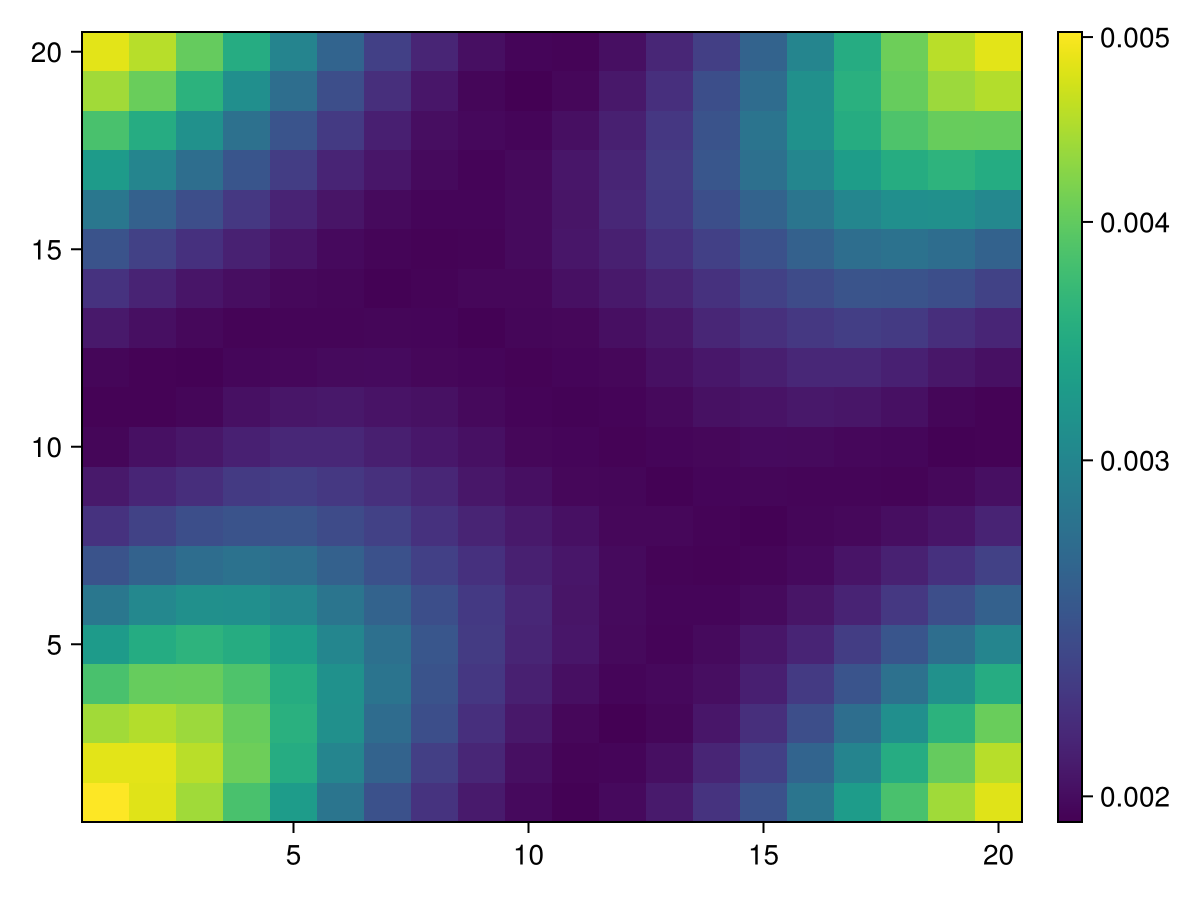

In [ ]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[10], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

In [ ]:
etak_corrs = results[:etak_corrs] ./ 400^2

10-element Vector{Array{Complex{Measurements.Measurement{Float64}}, 4}}:
 [0.00093 ± 1.0e-5 + 0.0 ± 0.0im 0.0009387 ± 6.6e-6 + 0.0 ± 0.0im … 0.0009163 ± 6.1e-6 + 0.0 ± 0.0im 0.0009387 ± 6.6e-6 + 0.0 ± 0.0im; 0.0009469 ± 6.8e-6 + 0.0 ± 0.0im 0.0009318 ± 6.8e-6 + 0.0 ± 0.0im … 0.0009032 ± 6.9e-6 + 0.0 ± 0.0im 0.0009252 ± 6.9e-6 + 0.0 ± 0.0im; … ; 0.0009183 ± 7.1e-6 + 0.0 ± 0.0im 0.0009175 ± 4.9e-6 + 0.0 ± 0.0im … 0.0009358 ± 7.3e-6 + 0.0 ± 0.0im 0.0009351 ± 4.3e-6 + 0.0 ± 0.0im; 0.0009469 ± 6.8e-6 + 0.0 ± 0.0im 0.0009252 ± 6.9e-6 + 0.0 ± 0.0im … 0.0009237 ± 5.1e-6 + 0.0 ± 0.0im 0.0009318 ± 6.8e-6 + 0.0 ± 0.0im;;; -2.6e-7 ± 5.7e-6 + 0.0 ± 0.0im -1.7e-6 ± 6.6e-6 + 3.904732438354213e-6 ± 0.0im … 1.39e-5 ± 5.9e-6 - 1.9029594609173106e-6 ± 0.0im -1.7e-6 ± 6.6e-6 - 3.904732438354213e-6 ± 0.0im; -3.1e-6 ± 6.2e-6 - 9.377561095449098e-6 ± 0.0im 5.6e-6 ± 5.5e-6 + 3.1815531195681957e-6 ± 0.0im … -6.4e-6 ± 6.7e-6 - 1.5513797444897643e-6 ± 0.0im 1.6e-7 ± 7.7e-6 + 1.3551836503258434e-6 ± 0.0im; … ; -8

Maximum correlation norm: 0.0009519 ± 8.6e-6

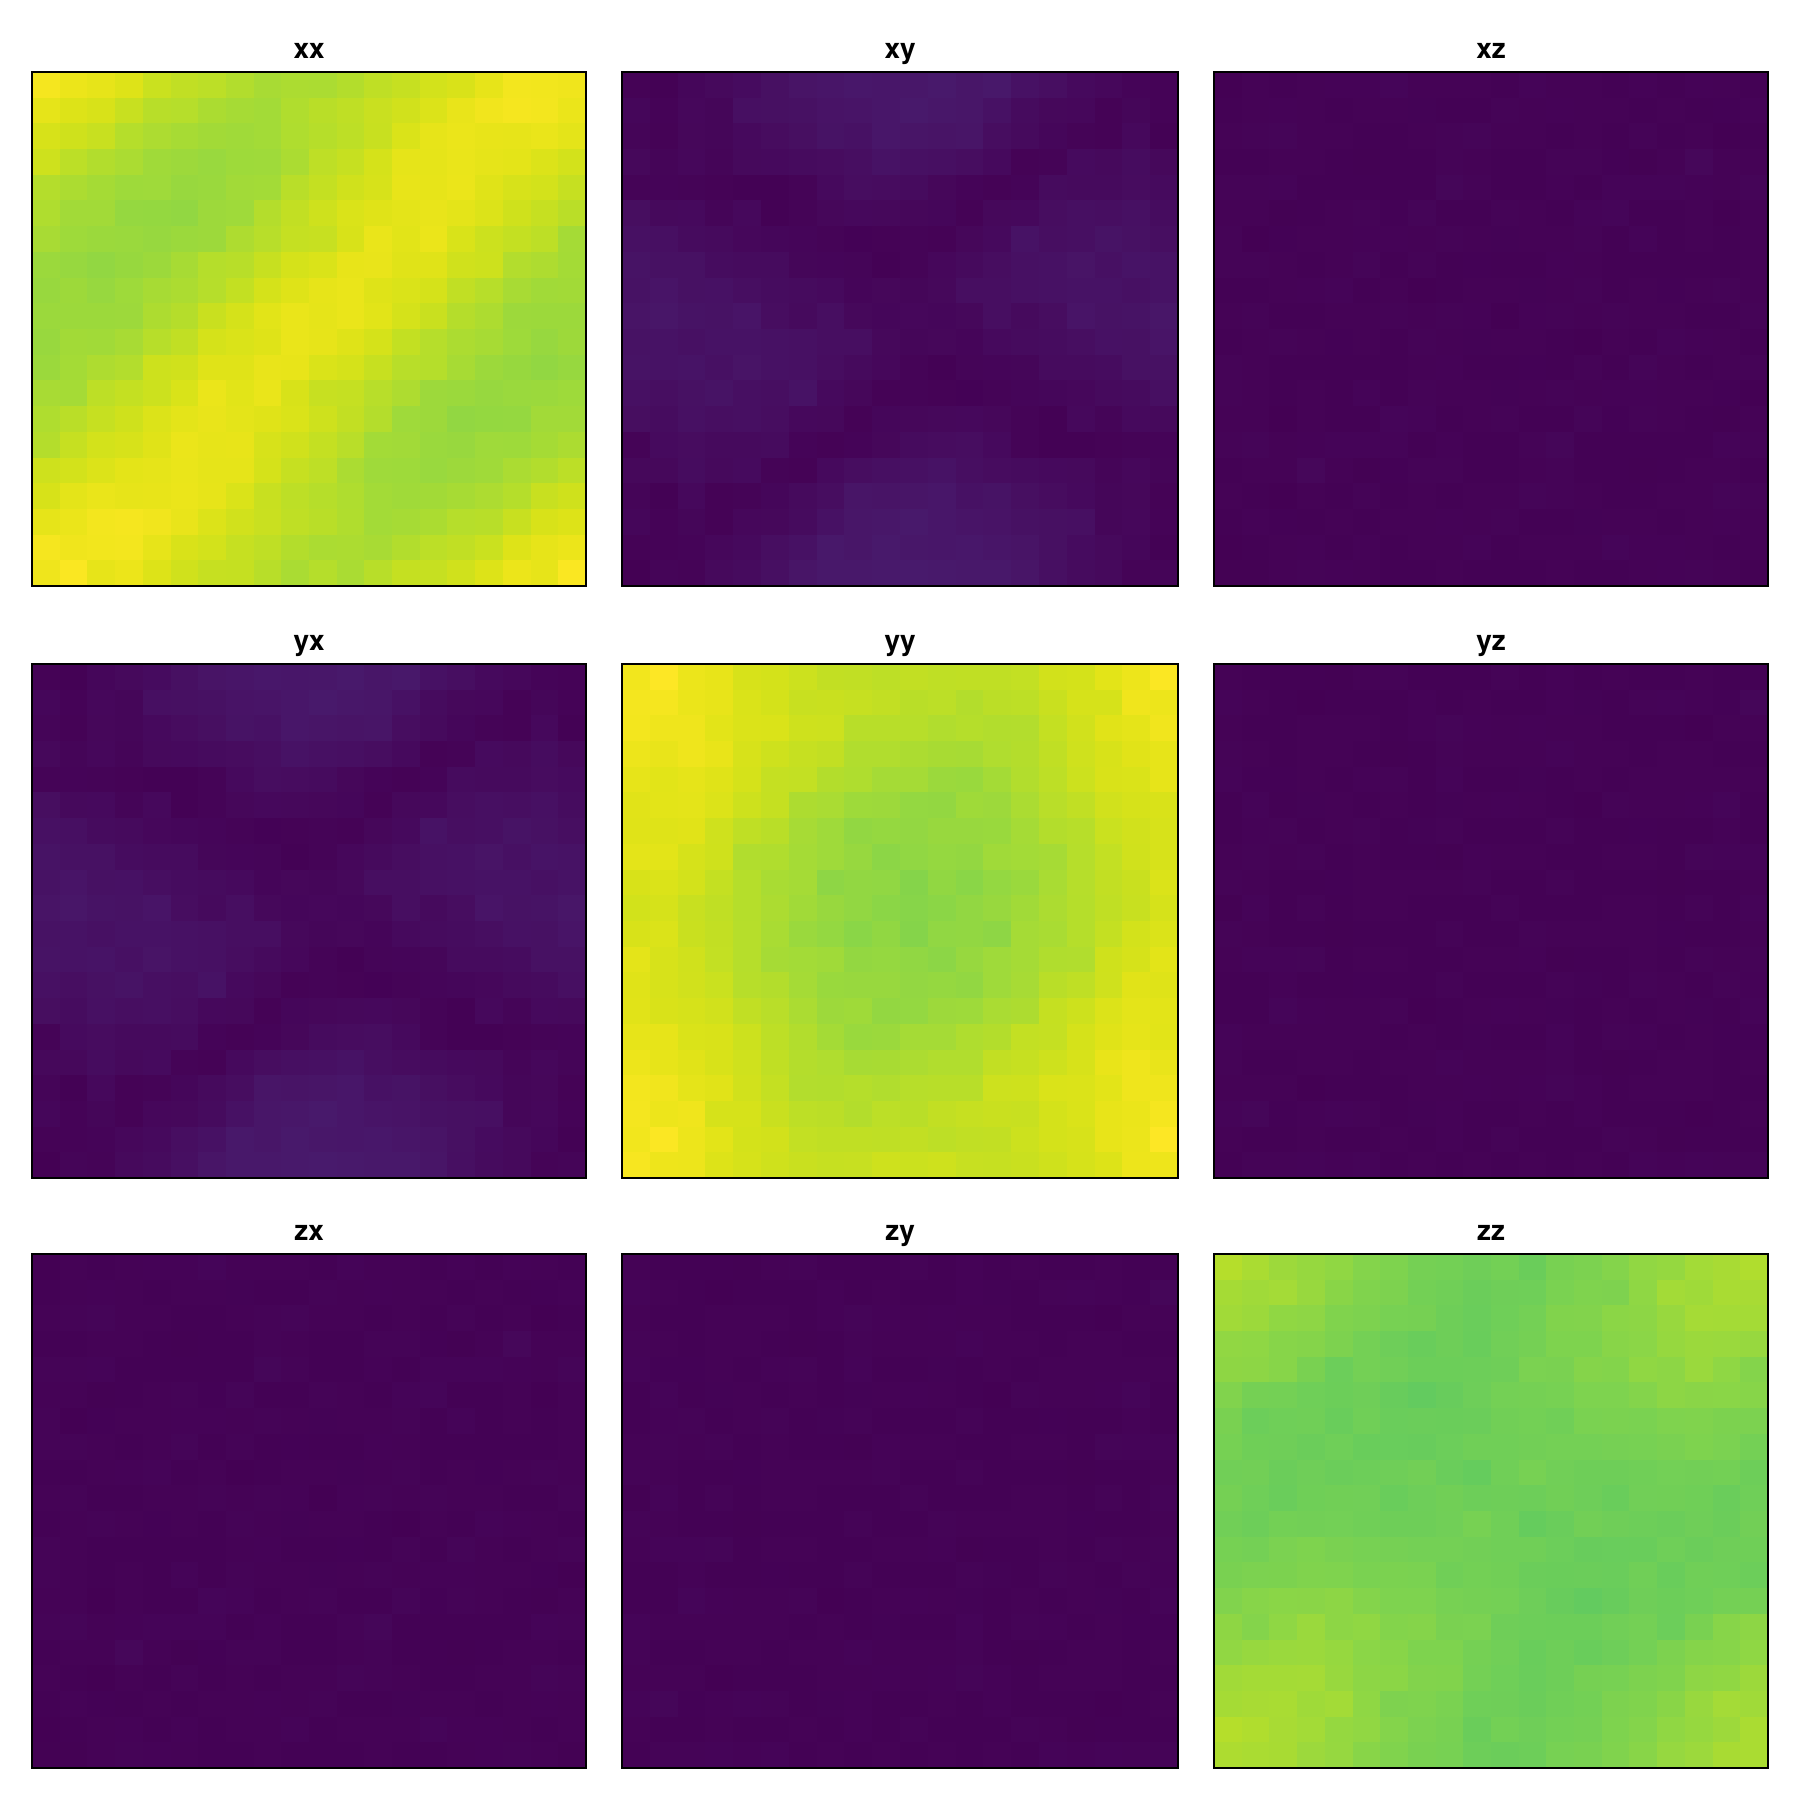

In [ ]:
CairoMakie.activate!()

i = 1
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

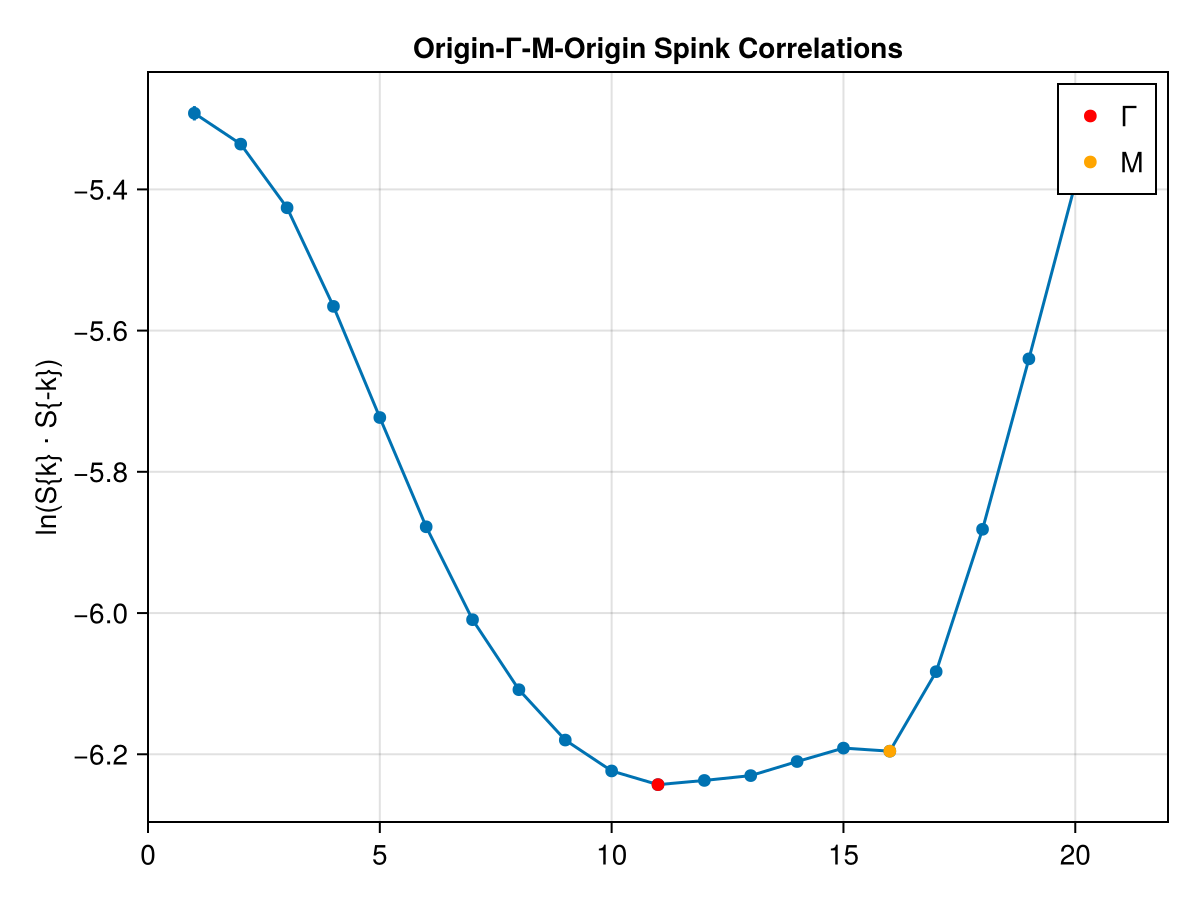

In [ ]:
CairoMakie.activate!()
task_no = 10
Lx, Ly = size(spink_corrs[task_no])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

Γ_path = [(i, 1) for i in 1:borderx]
M_path = [(borderx, i) for i in 2:(div(bordery, 2) + 1)]
O_path = [(borderx - 2i, div(bordery, 2) - i + 1) for i in 1:div(borderx, 2)]
path = cat(Γ_path, M_path, O_path, dims=1)

Γ_pos = length(Γ_path)
M_pos = length(Γ_path) + length(M_path)
corrs = [spink_corrs[task_no][I...] for I in path]

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
log_corrs = log.(corrs)
scatter!(ax, log_corrs)
errorbars!(ax, 1:length(path), getfield.(log_corrs, :val), getfield.(log_corrs, :err))
lines!(ax, log_corrs)
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

In [ ]:
to_triangle((x, y)) = ((x-1), (-(x-1) + 2(y-1)) / sqrt(3)) ./ 20
positions = to_triangle.(Iterators.product(axes(getfield.(spink_corrs[1], :val))...))

20×20 Matrix{Tuple{Float64, Float64}}:
 (0.0, 0.0)          …  (0.0, 1.03923)    (0.0, 1.09697)
 (0.05, -0.0288675)     (0.05, 1.01036)   (0.05, 1.0681)
 (0.1, -0.057735)       (0.1, 0.981495)   (0.1, 1.03923)
 (0.15, -0.0866025)     (0.15, 0.952628)  (0.15, 1.01036)
 (0.2, -0.11547)        (0.2, 0.92376)    (0.2, 0.981495)
 (0.25, -0.144338)   …  (0.25, 0.894893)  (0.25, 0.952628)
 (0.3, -0.173205)       (0.3, 0.866025)   (0.3, 0.92376)
 (0.35, -0.202073)      (0.35, 0.837158)  (0.35, 0.894893)
 (0.4, -0.23094)        (0.4, 0.80829)    (0.4, 0.866025)
 (0.45, -0.259808)      (0.45, 0.779423)  (0.45, 0.837158)
 (0.5, -0.288675)    …  (0.5, 0.750555)   (0.5, 0.80829)
 (0.55, -0.317543)      (0.55, 0.721688)  (0.55, 0.779423)
 (0.6, -0.34641)        (0.6, 0.69282)    (0.6, 0.750555)
 (0.65, -0.375278)      (0.65, 0.663953)  (0.65, 0.721688)
 (0.7, -0.404145)       (0.7, 0.635085)   (0.7, 0.69282)
 (0.75, -0.433013)   …  (0.75, 0.606218)  (0.75, 0.663953)
 (0.8, -0.46188)        (0.8, 0.5

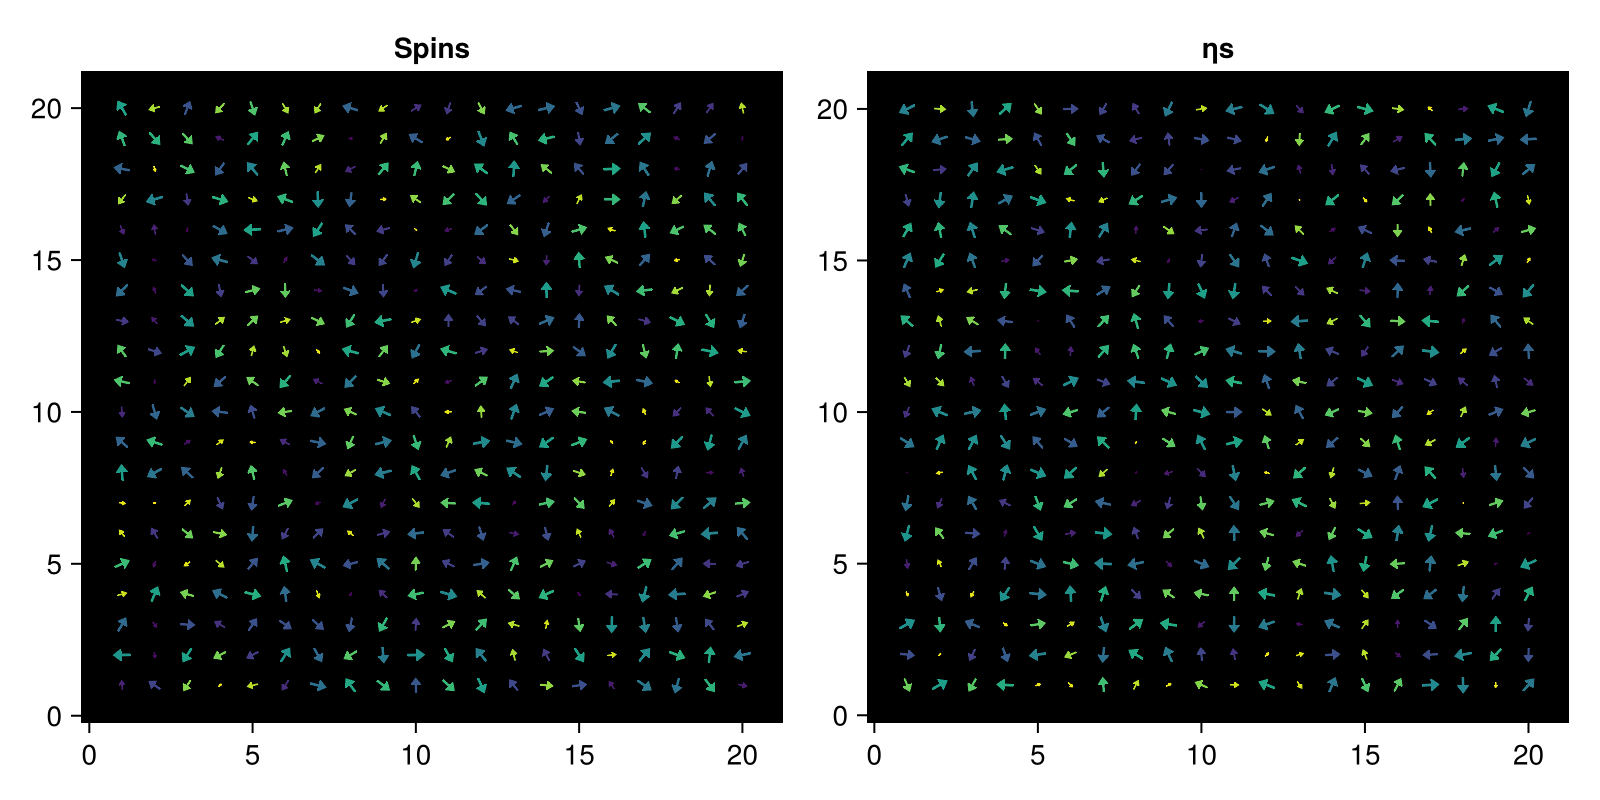

In [ ]:
generate_spins("stripe-anneal", 1)

## Annealed Bias Field

In [ ]:
bias_results = JobResult("../jobs", "stripe-bias")
separate_etaks!(eta_results.data)
eta_results

JobResult("../jobs", "stripe-bias", 11×34 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.023091±9.5e-5     0.01     10.0  Complex{Measurement{Float64}}[0.…  0 ⋯
   2 │ 0.02299±0.00012     0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   3 │ 0.0231±0.00013      0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   4 │ 0.02282±0.00015     0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   5 │ 0.022977±8.9e-5     0.01     10.0  Complex{Measurement{Float64}}[0.…  0 ⋯
   6 │ 0.02275±0.00014     0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   7 │ 0.02224±0.00016     0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   8 │ 0.021582±7.5e-5     0.01     10.0  Complex{Measurement{Float64}}[0.…  0
   9 │ 0.02115±0.00012     0.01     10.0  Complex{Measurement{Float64

In [33]:
bias_results[[:_ll_sweep_time, :_ll_measure_time]]

11×2 DataFrame
 Row │ _ll_sweep_time     _ll_measure_time  
     │ Measurement…       Measurement…      
─────┼──────────────────────────────────────
   1 │ 0.00057802±3.9e-7  0.000192±2.0e-5
   2 │ 0.000436±2.9e-5    0.000133±1.2e-5
   3 │ 0.00035727±2.2e-7  0.0001046±2.0e-6
   4 │ 0.00035697±2.8e-7  0.000119±1.4e-5
   5 │ 0.00035561±1.3e-7  0.0001051±2.5e-6
   6 │ 0.00035437±1.3e-7  0.00010266±4.5e-7
   7 │ 0.00035395±2.7e-7  0.0001035±1.1e-6
   8 │ 0.0003535±1.2e-7   0.0001073±3.2e-6
   9 │ 0.00035181±1.7e-7  0.0001029±3.4e-7
  10 │ 0.00035077±1.8e-7  0.00010283±4.0e-7
  11 │ 0.00035128±2.4e-7  0.0001077±3.4e-6

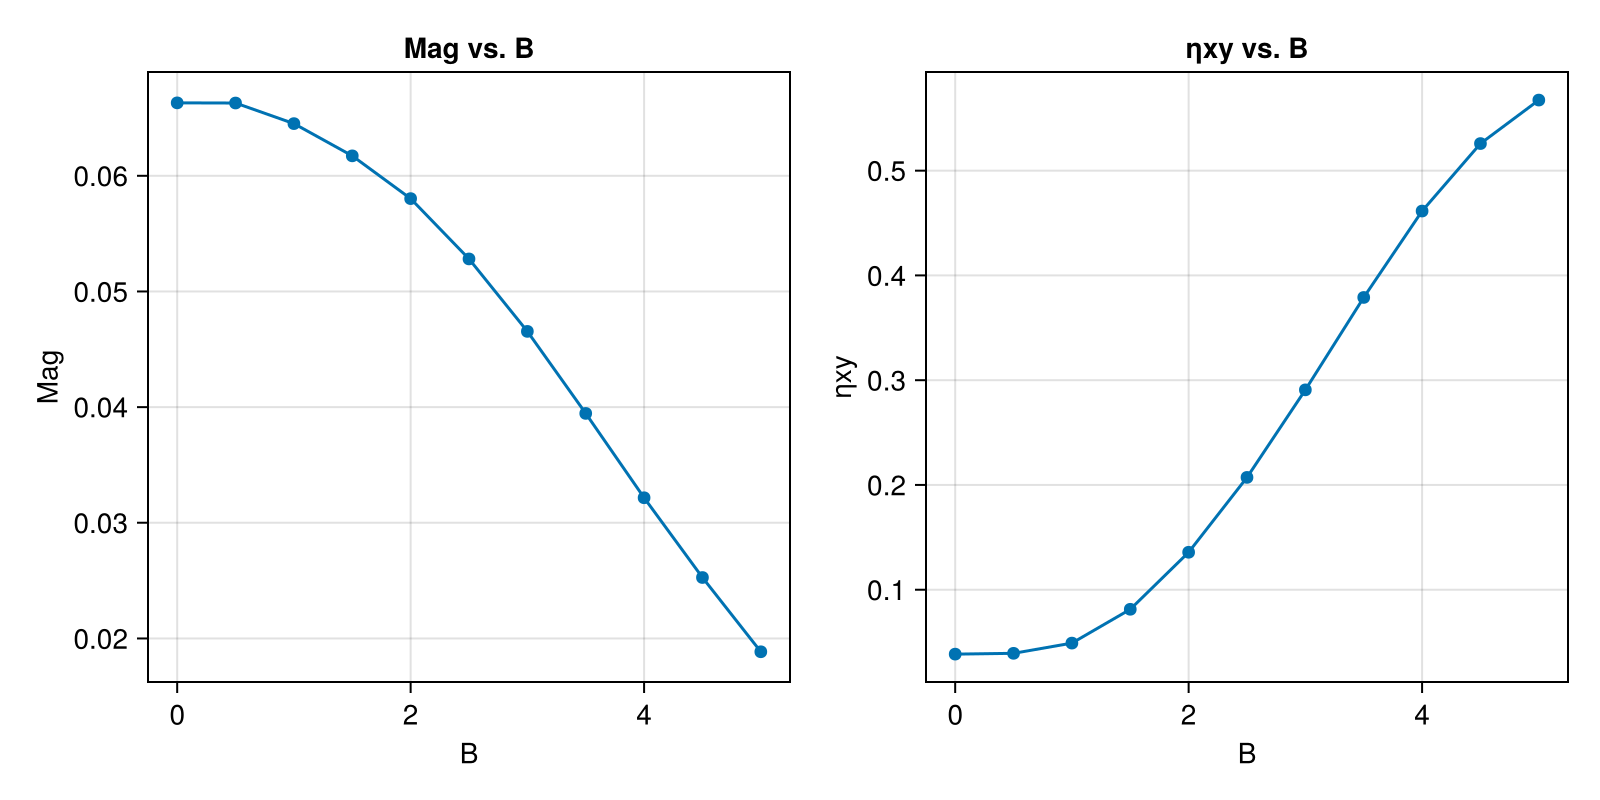

In [34]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. B", xlabel="B", ylabel="Mag")
generate_plot!(ax_s, :B, :Mag, bias_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. B", xlabel="B", ylabel="ηxy")
generate_plot!(ax_η, :B, :ηxy, bias_results.data; line=true)
fig

In [36]:
bias_mctimes = get_mctime_data(bias_results, :etak_corrs)
separate_etaks!.(bias_mctimes)
bias_mctimes

11-element Vector{DataFrame}:
 100×10 DataFrame
 Row │ etak_corrs                         ηk_xx                              η ⋯
     │ SubArray…                          Array…                             A ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[0.00119118+0.0im 0.00…  ComplexF64[0.00119118+0.0im 0.00…  C ⋯
   2 │ ComplexF64[0.0010023+0.0im 0.000…  ComplexF64[0.0010023+0.0im 0.000…  C
   3 │ ComplexF64[0.000829377+0.0im 0.0…  ComplexF64[0.000829377+0.0im 0.0…  C
   4 │ ComplexF64[0.000960414+0.0im 0.0…  ComplexF64[0.000960414+0.0im 0.0…  C
   5 │ ComplexF64[0.000929046+0.0im 0.0…  ComplexF64[0.000929046+0.0im 0.0…  C ⋯
   6 │ ComplexF64[0.00115132+0.0im 0.00…  ComplexF64[0.00115132+0.0im 0.00…  C
   7 │ ComplexF64[0.000868356+0.0im 0.0…  ComplexF64[0.000868356+0.0im 0.0…  C
   8 │ ComplexF64[0.00102516+0.0im 0.00…  ComplexF64[0.00102516+0.0im 0.00…  C
  ⋮  │                 ⋮                                  ⋮              

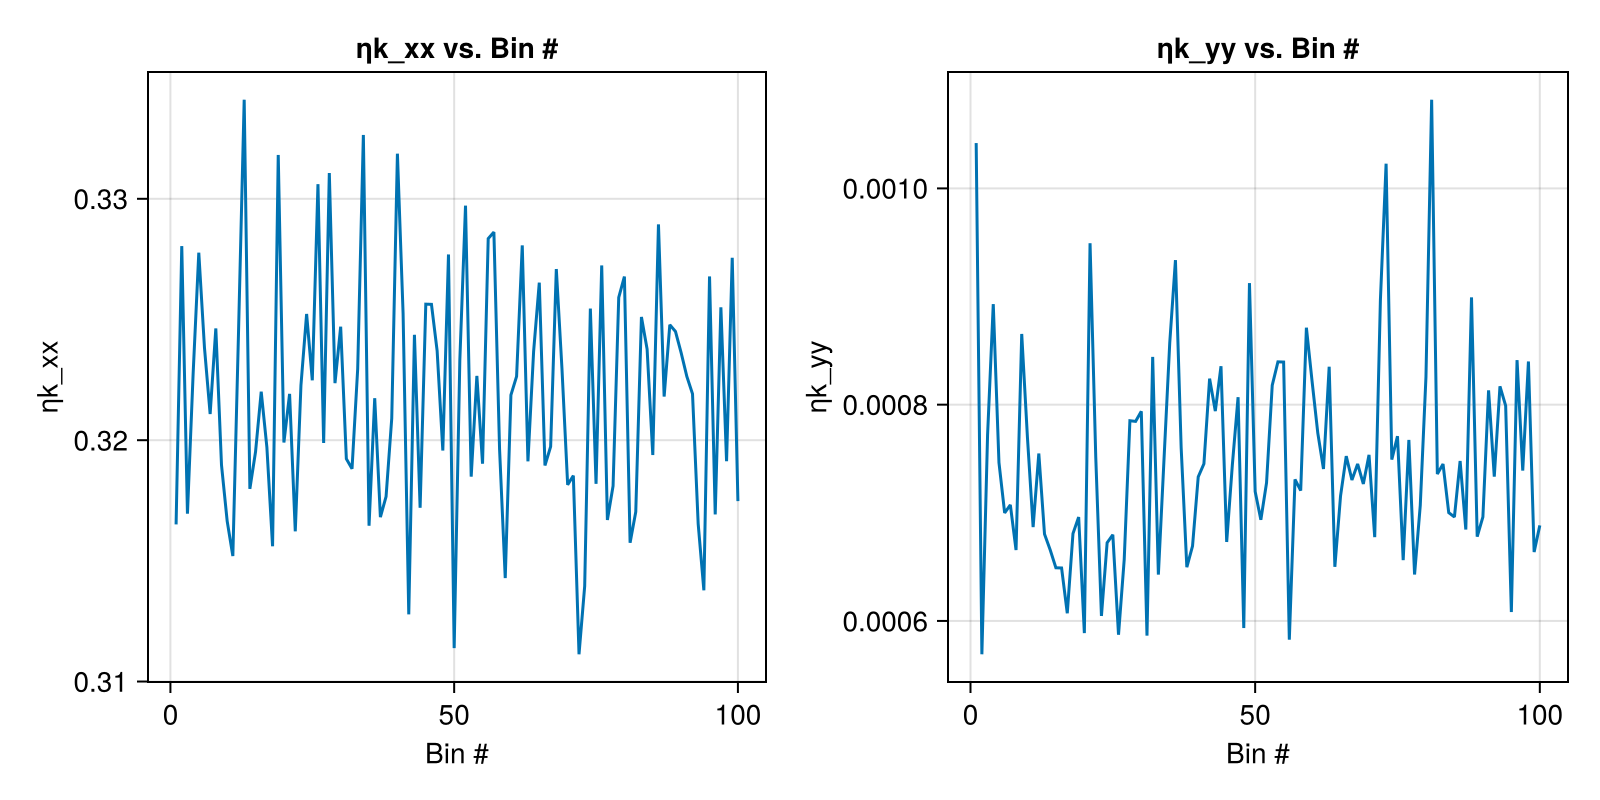

In [37]:
CairoMakie.activate!()
i = 11
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(bias_mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(bias_mctimes[i][:, var2], k_pos...)))
fig

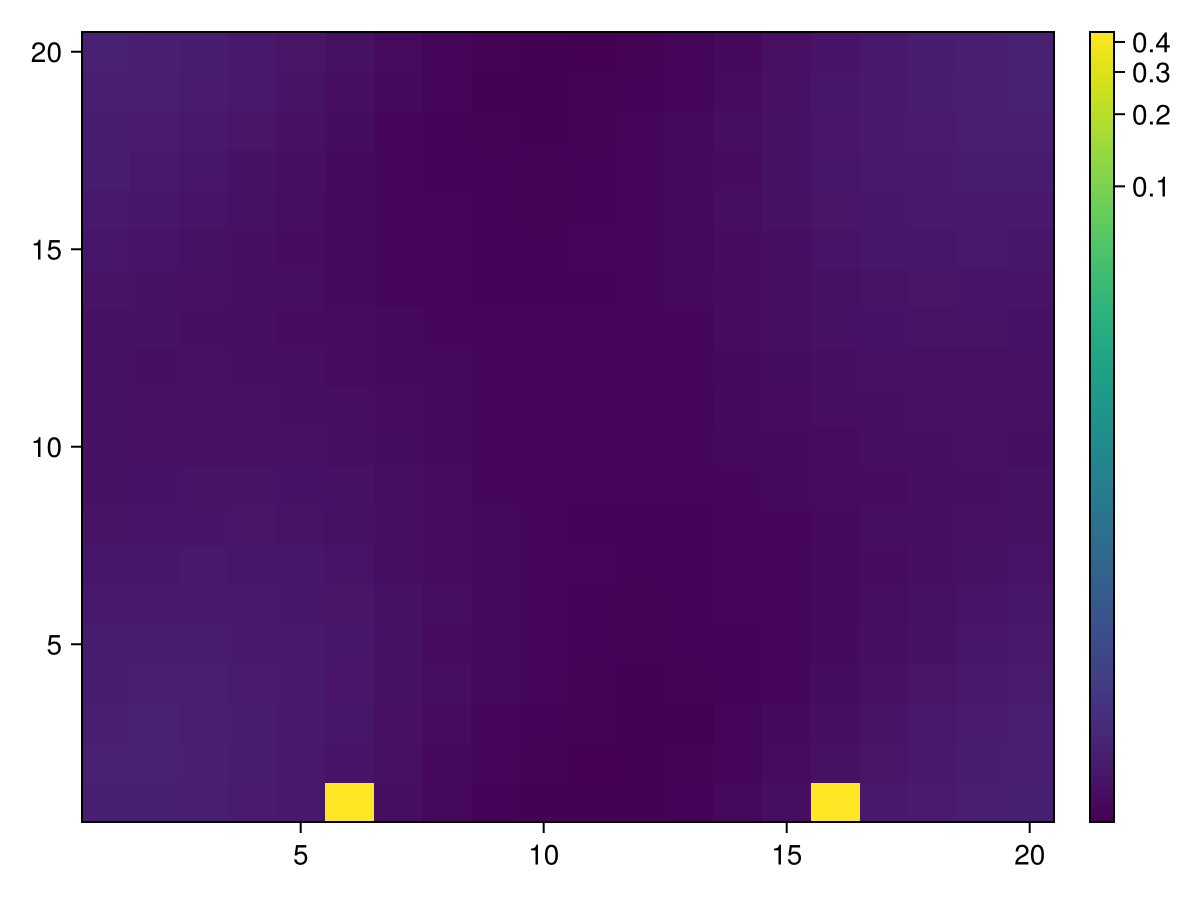

In [38]:
CairoMakie.activate!()
spink_corrs = bias_results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[11], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

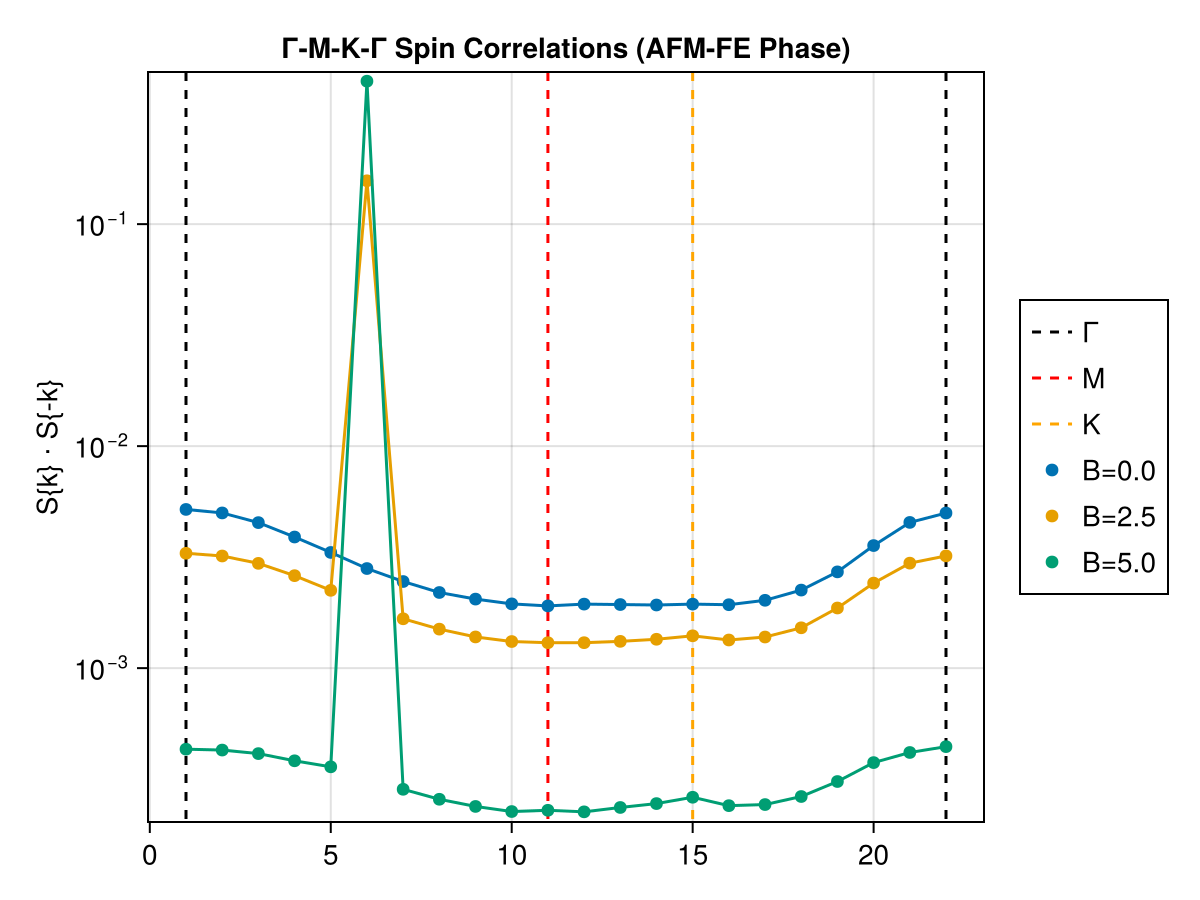

In [39]:
CairoMakie.activate!()
is = [1, 6, 11]

spink_corrs = bias_results[:spink_corrs]
Bs = bias_results[:B]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[i][I...] for I in path for i in is], :val))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.([spink_corrs[i][I...] for I in path for i in is], :val))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (19, 10), (17, 9), (15, 8), (13, 7), (14, 6), (15, 5), (16, 4), (17, 3), (18, 2), (19, 1)]


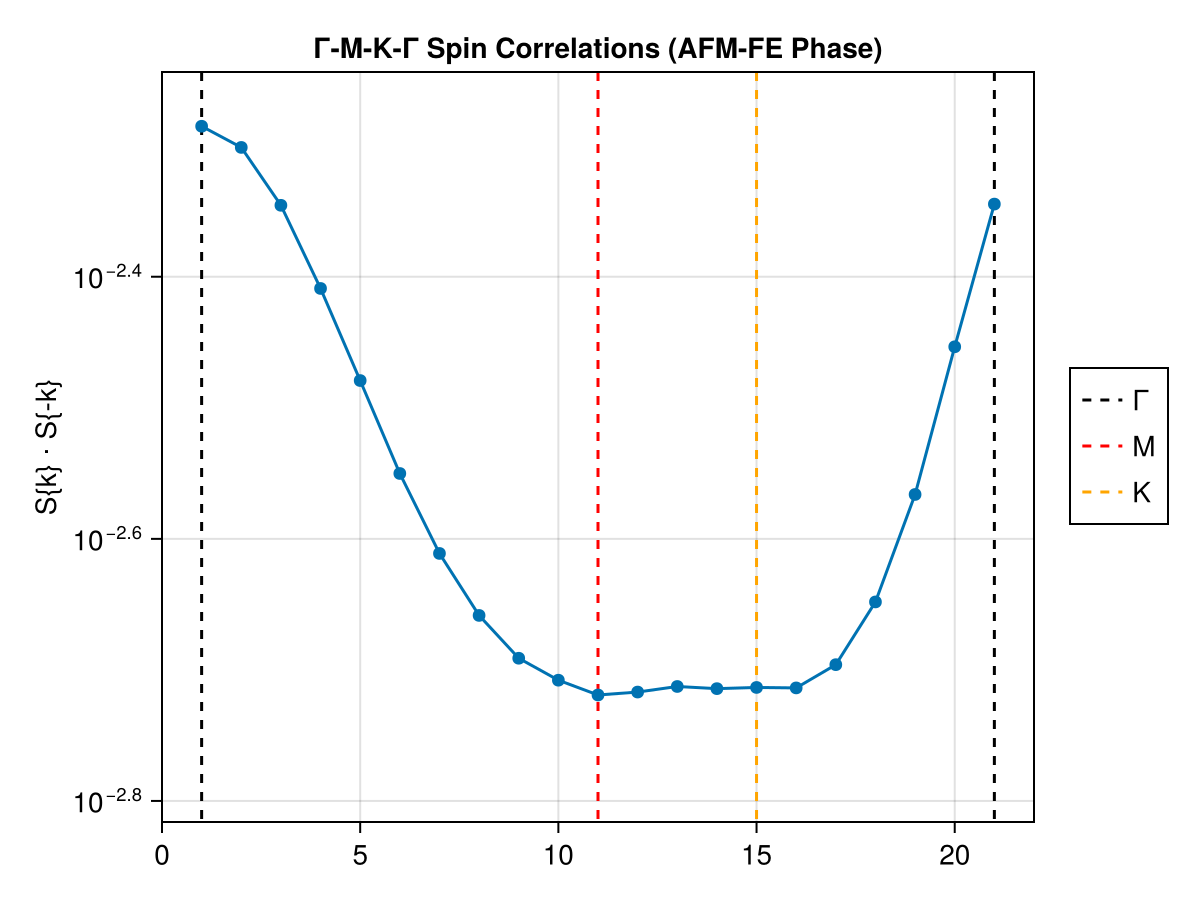

In [40]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (20, 20), (19, 19), (18, 18), (17, 17), (16, 16), (15, 15), (14, 14), (13, 13), (12, 12), (11, 11), (12, 10), (13, 9), (14, 8), (15, 7), (16, 9), (17, 11), (18, 13), (19, 15), (20, 17), (1, 19), (2, 1)]


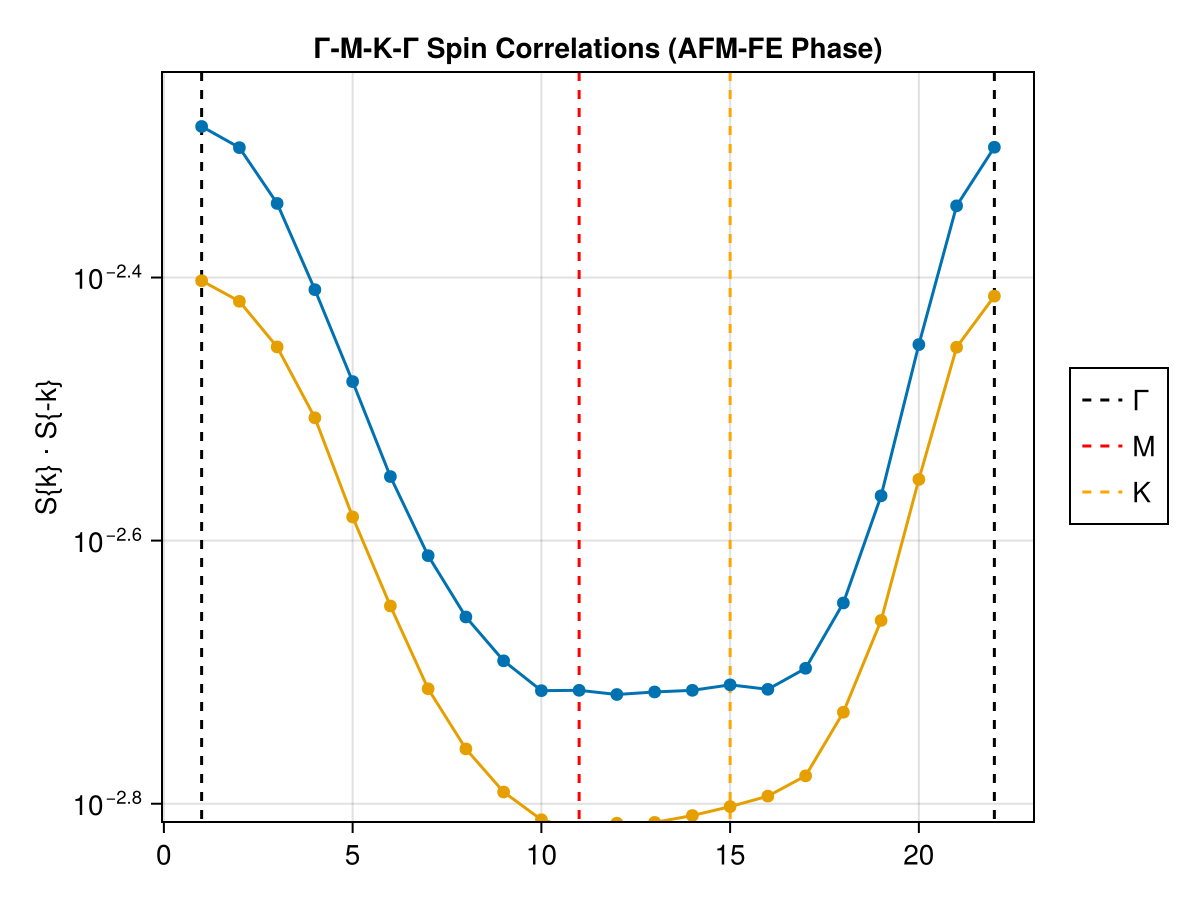

In [41]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1, 5, 11]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

In [42]:
CairoMakie.activate!()

i = 1
Lx = 40
etak_corrs = anneal_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

UndefVarError: UndefVarError: `anneal_results` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

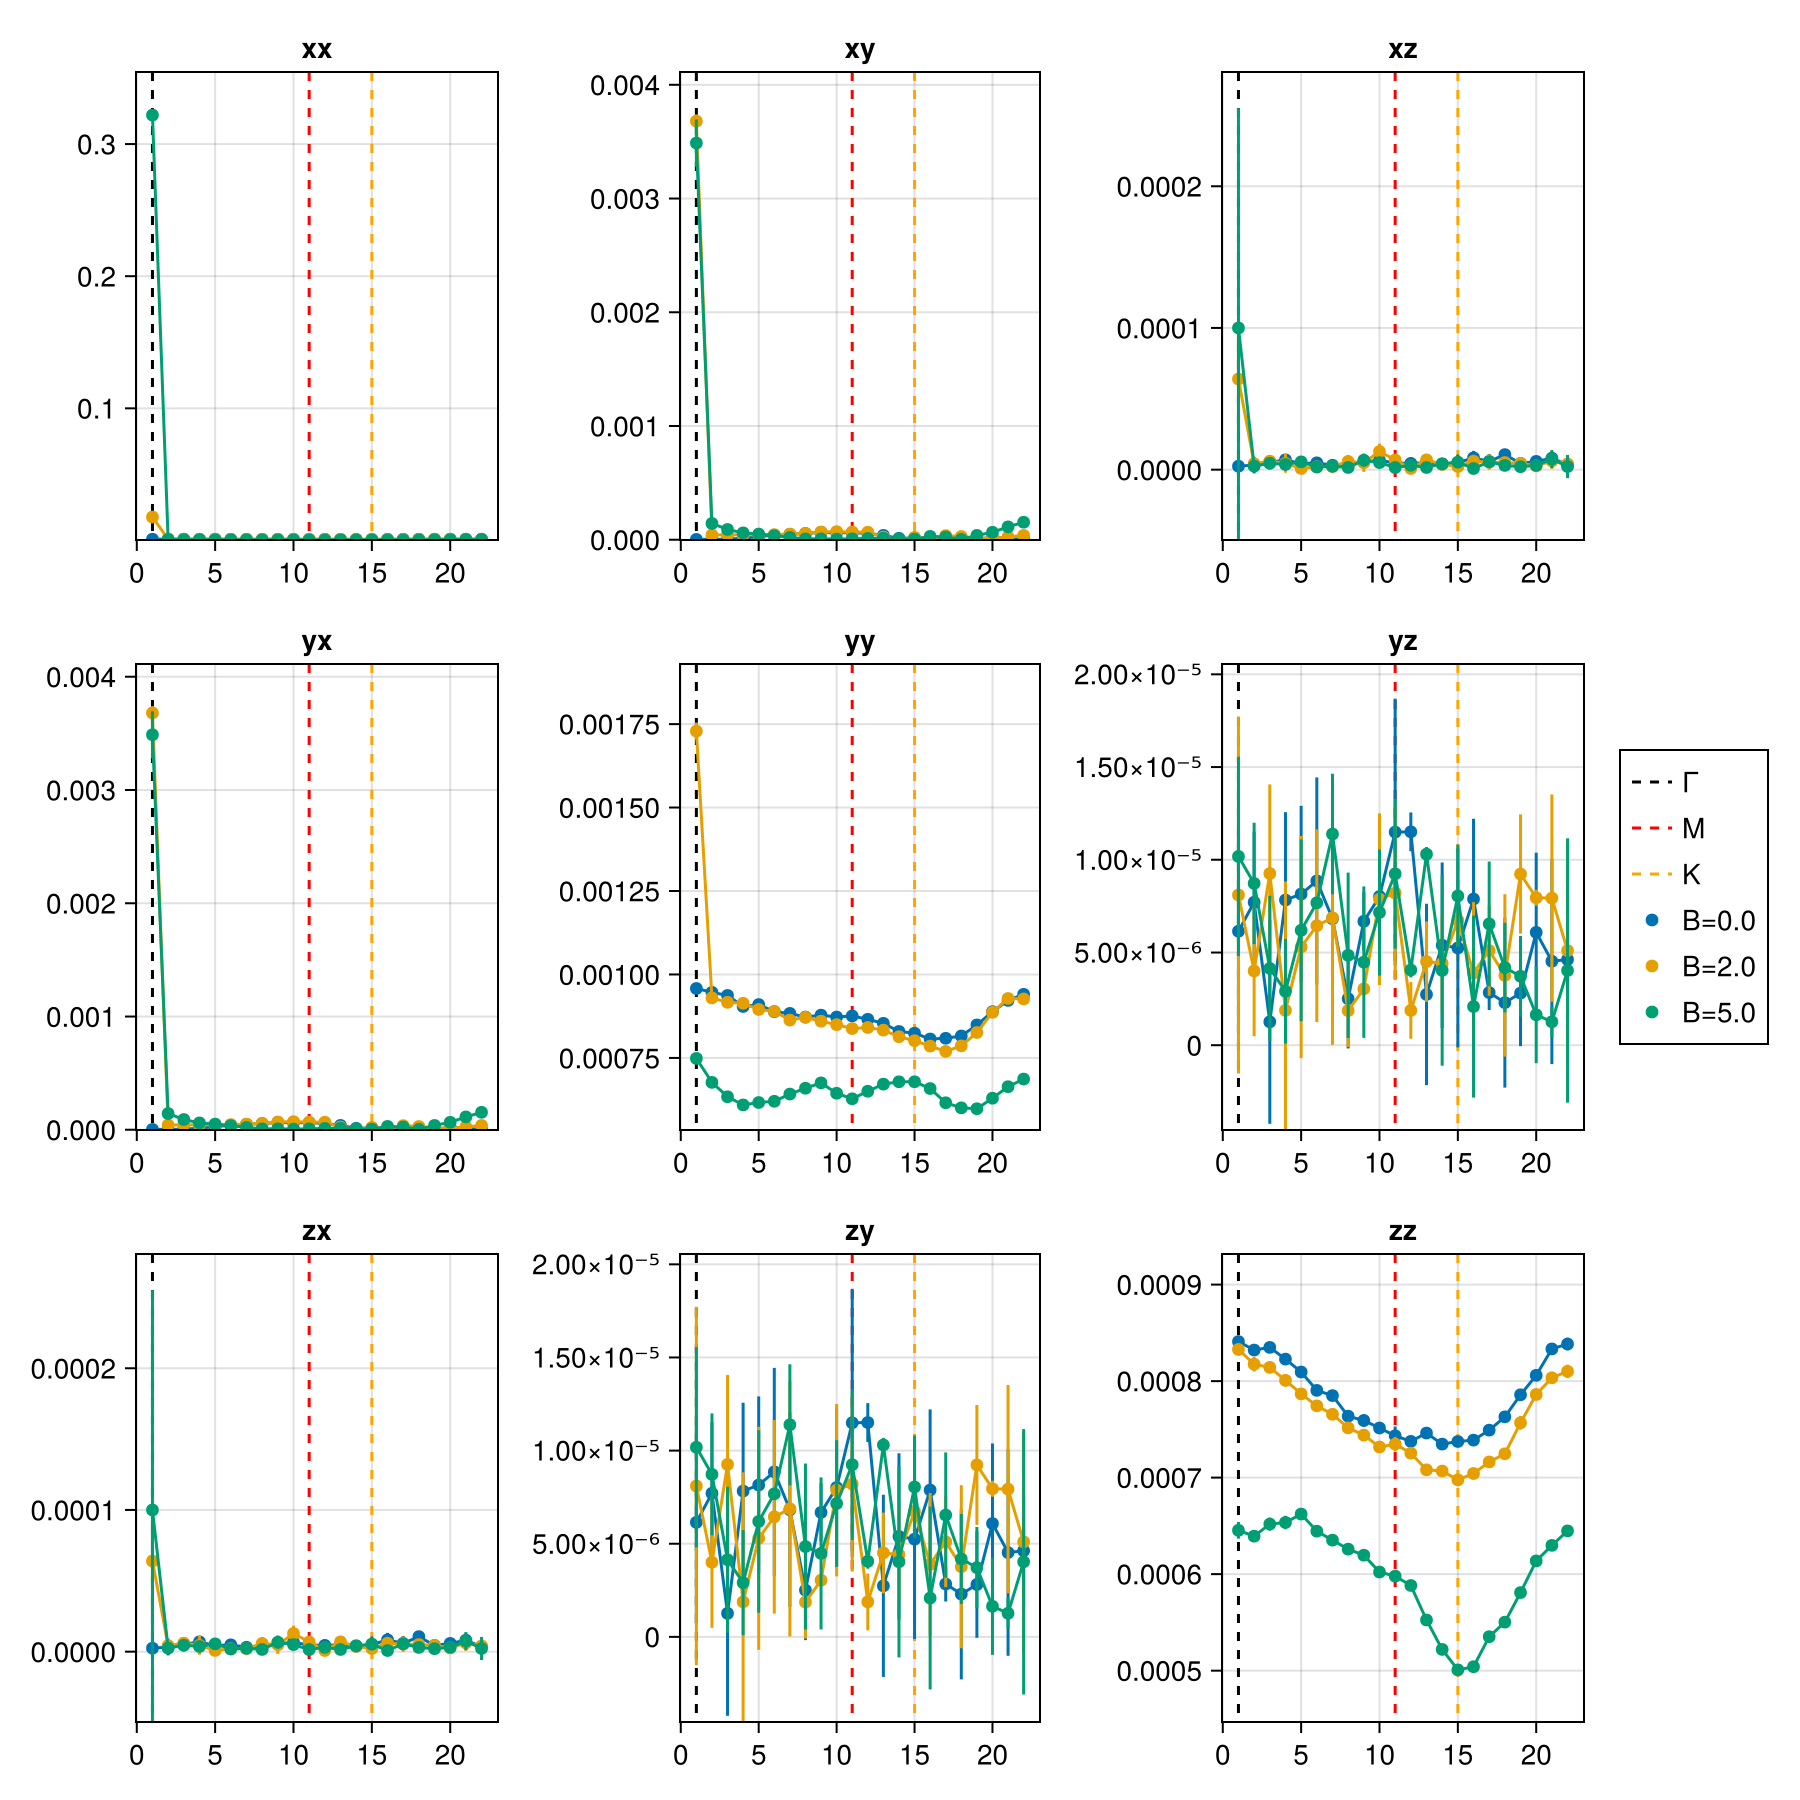

In [44]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 11]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## Eta-Only Runs

In [76]:
eta_results = JobResult("../jobs", "stripe-eta")
separate_etaks!(eta_results.data)
eta_results

JobResult("../jobs", "stripe-eta", 11×32 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.00408±0.00012     0.01  Complex{Measurement{Float64}}[0.…  0.000275±8 ⋯
   2 │ 0.02063±0.00012     0.5   Complex{Measurement{Float64}}[0.…  0.0002889±
   3 │ 0.02226±0.00013     1.0   Complex{Measurement{Float64}}[0.…  0.000298±1
   4 │ 0.022748±6.9e-5     1.5   Complex{Measurement{Float64}}[0.…  0.00027634
   5 │ 0.022829±9.5e-5     2.0   Complex{Measurement{Float64}}[0.…  0.00027543 ⋯
   6 │ 0.022923±7.5e-5     2.5   Complex{Measurement{Float64}}[0.…  0.00027545
   7 │ 0.02298±0.0001      3.0   Complex{Measurement{Float64}}[0.…  0.00027389
   8 │ 0.023093±8.6e-5     3.5   Complex{Measurement{Float64}}[0.…  0.00027448
   9 │ 0.022963±6.9e-5     4.0   Complex{Measurement{Float64}}[0.…  0.

In [77]:
eta_results[[:_ll_sweep_time, :_ll_measure_time]]

11×2 DataFrame
 Row │ _ll_sweep_time     _ll_measure_time  
     │ Measurement…       Measurement…      
─────┼──────────────────────────────────────
   1 │ 0.000275±8.4e-6    0.000193±1.7e-5
   2 │ 0.0002889±8.8e-6   0.000196±1.3e-5
   3 │ 0.000298±1.6e-5    0.00019±1.5e-5
   4 │ 0.00027634±2.8e-7  0.0001598±4.9e-7
   5 │ 0.00027543±1.5e-7  0.0001735±8.8e-6
   6 │ 0.00027545±2.8e-7  0.00016254±4.5e-7
   7 │ 0.00027389±1.8e-7  0.00016255±4.0e-7
   8 │ 0.00027448±2.4e-7  0.0001696±4.3e-6
   9 │ 0.00102±0.00071    0.0087±0.0085
  10 │ 0.000303±2.4e-5    0.00019±2.5e-5
  11 │ 0.00027444±2.6e-7  0.0001746±9.4e-6

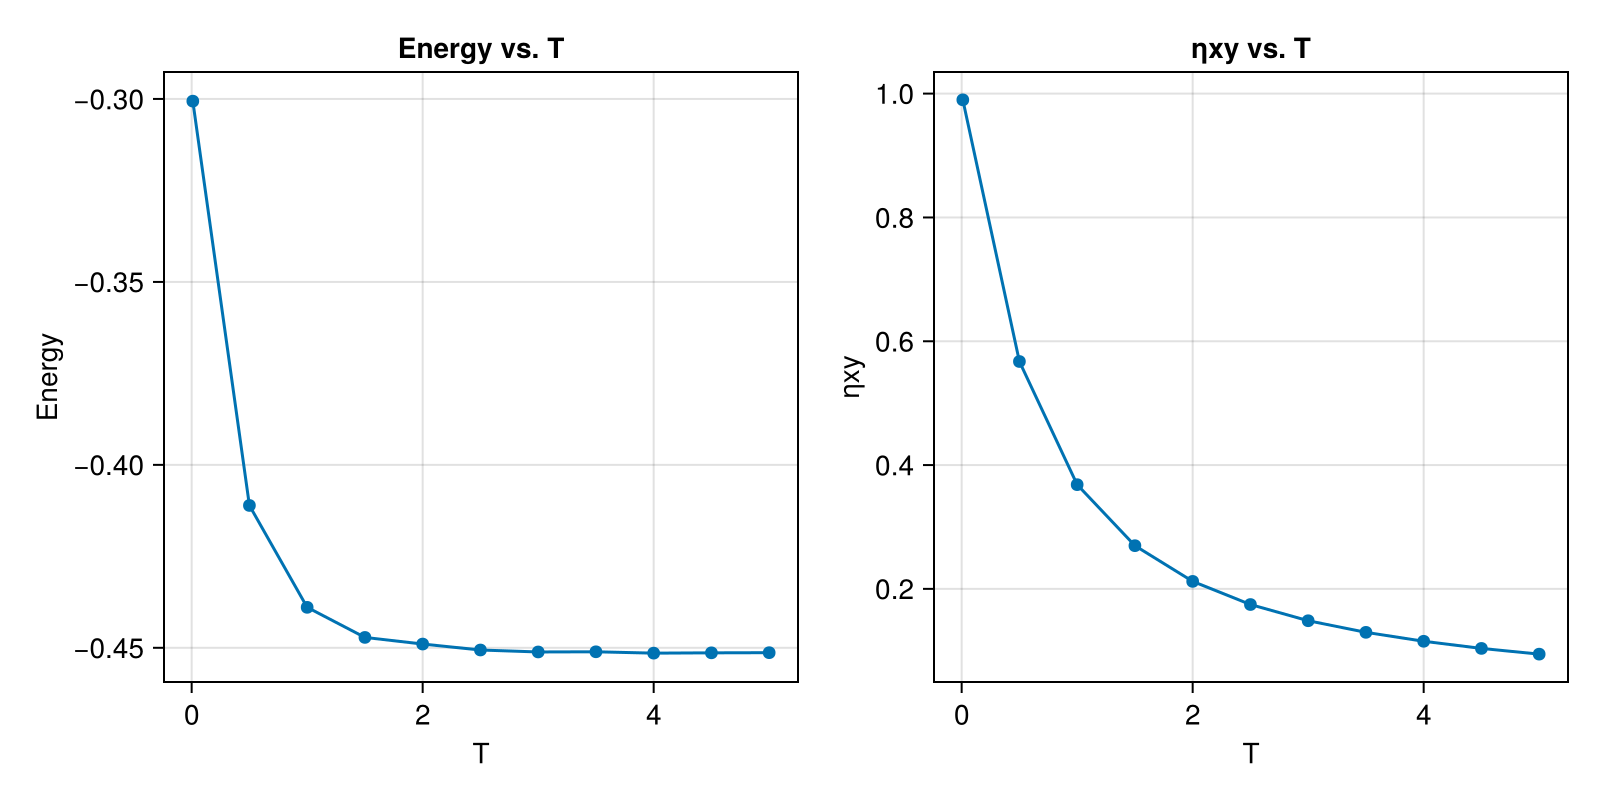

In [85]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax_s, :T, :Energy, eta_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, eta_results.data; line=true)
fig

In [79]:
eta_mctimes = get_mctime_data(eta_results, :etak_corrs)
separate_etaks!.(eta_mctimes)
eta_mctimes

11-element Vector{DataFrame}:
 100×10 DataFrame
 Row │ etak_corrs                         ηk_xx                              η ⋯
     │ SubArray…                          Array…                             A ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[0.910928+0.0im 2.5538…  ComplexF64[0.910928+0.0im 2.5538…  C ⋯
   2 │ ComplexF64[0.94854+0.0im 1.14063…  ComplexF64[0.94854+0.0im 1.14063…  C
   3 │ ComplexF64[0.949295+0.0im 1.6250…  ComplexF64[0.949295+0.0im 1.6250…  C
   4 │ ComplexF64[0.949377+0.0im 1.3711…  ComplexF64[0.949377+0.0im 1.3711…  C
   5 │ ComplexF64[0.948899+0.0im 1.9664…  ComplexF64[0.948899+0.0im 1.9664…  C ⋯
   6 │ ComplexF64[0.946556+0.0im 7.3217…  ComplexF64[0.946556+0.0im 7.3217…  C
   7 │ ComplexF64[0.947688+0.0im 9.7165…  ComplexF64[0.947688+0.0im 9.7165…  C
   8 │ ComplexF64[0.947909+0.0im 7.1536…  ComplexF64[0.947909+0.0im 7.1536…  C
  ⋮  │                 ⋮                                  ⋮              

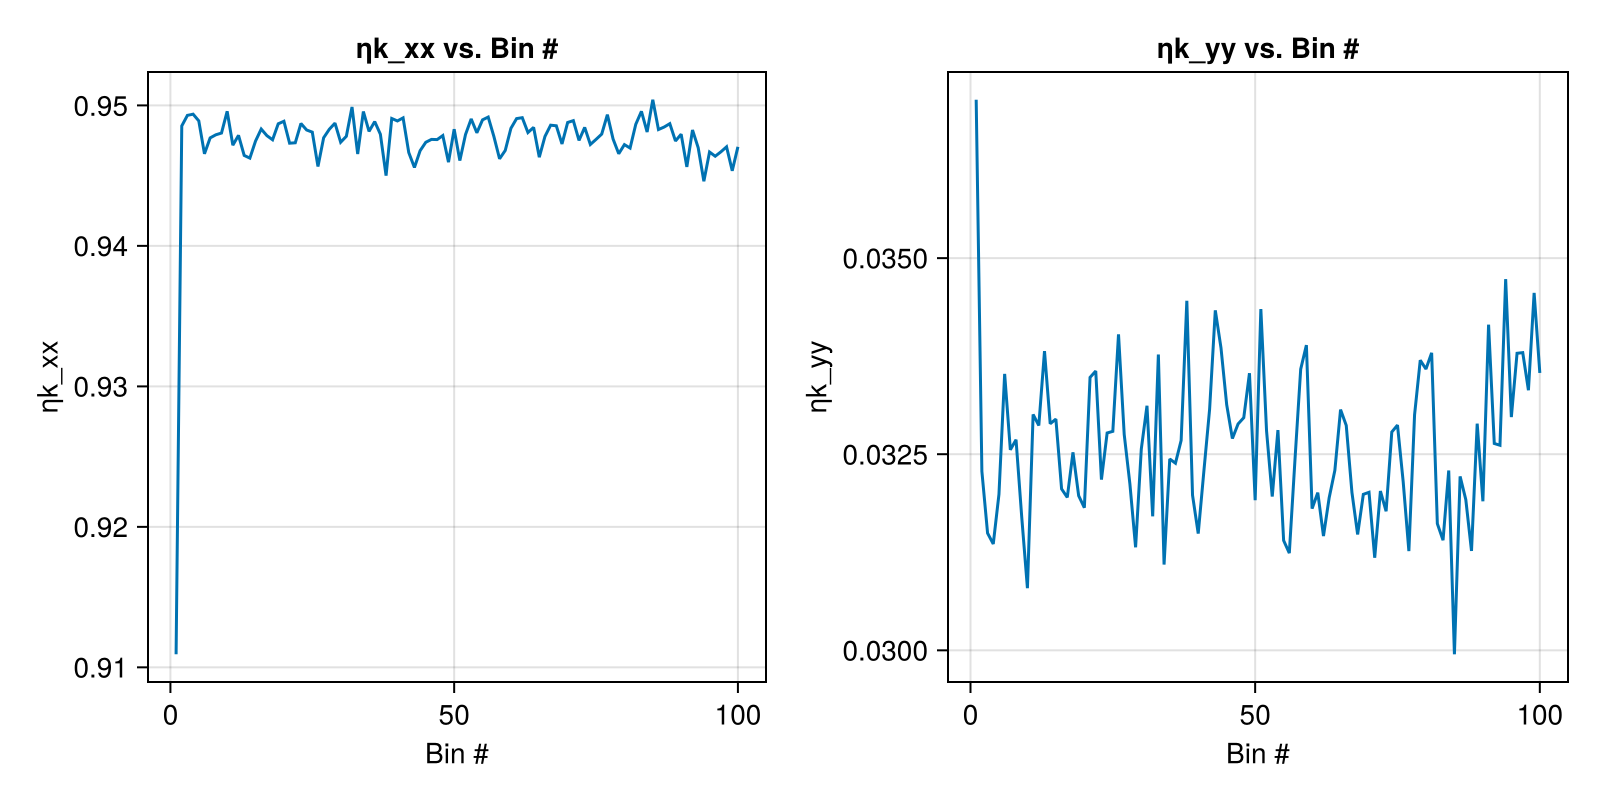

In [86]:
CairoMakie.activate!()
i = 1
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(eta_mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(eta_mctimes[i][:, var2], k_pos...)))
fig

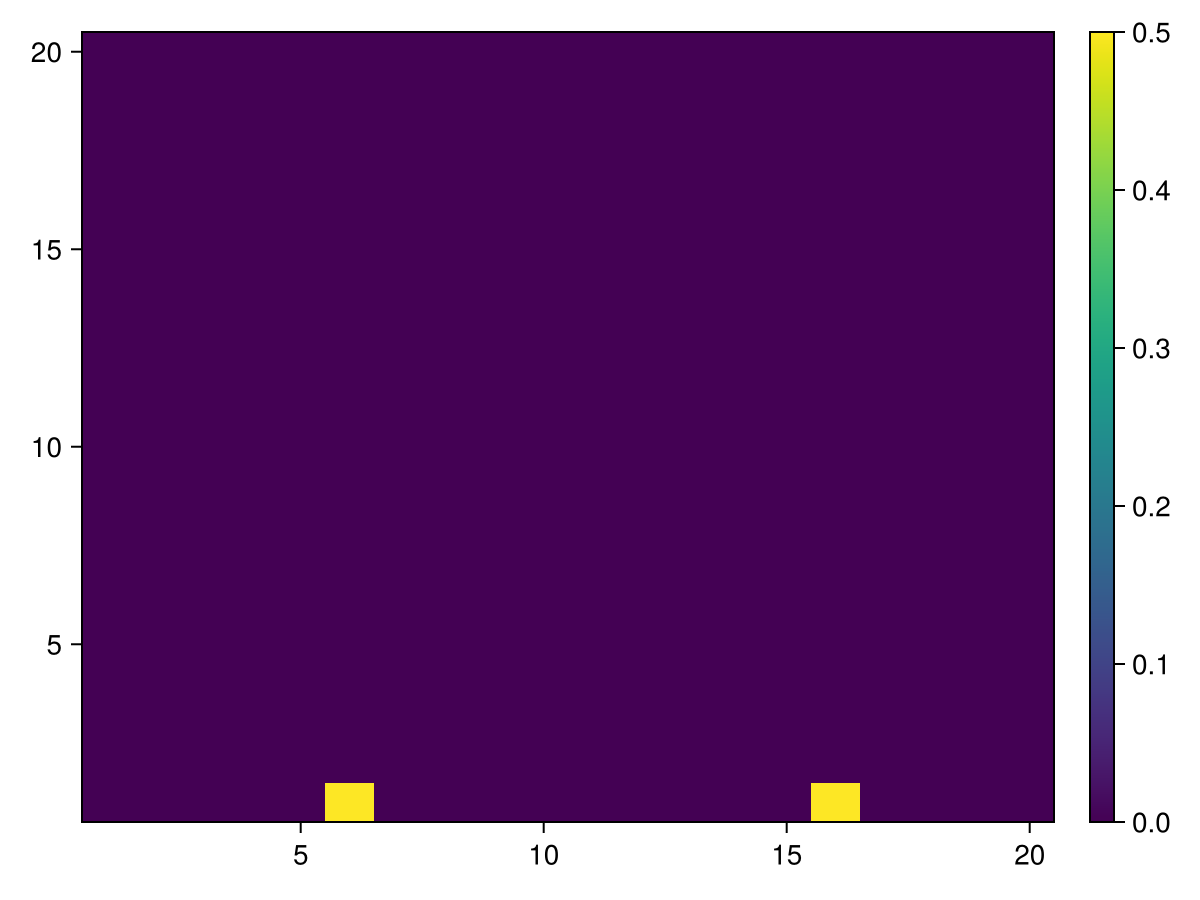

In [81]:
CairoMakie.activate!()
spink_corrs = eta_results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
fig, ax, hm = heatmap(getfield.(spink_corrs[11], :val))
Colorbar(fig[1, 2], hm)
fig

Maximum correlation norm: 0.94746 ± 0.00036

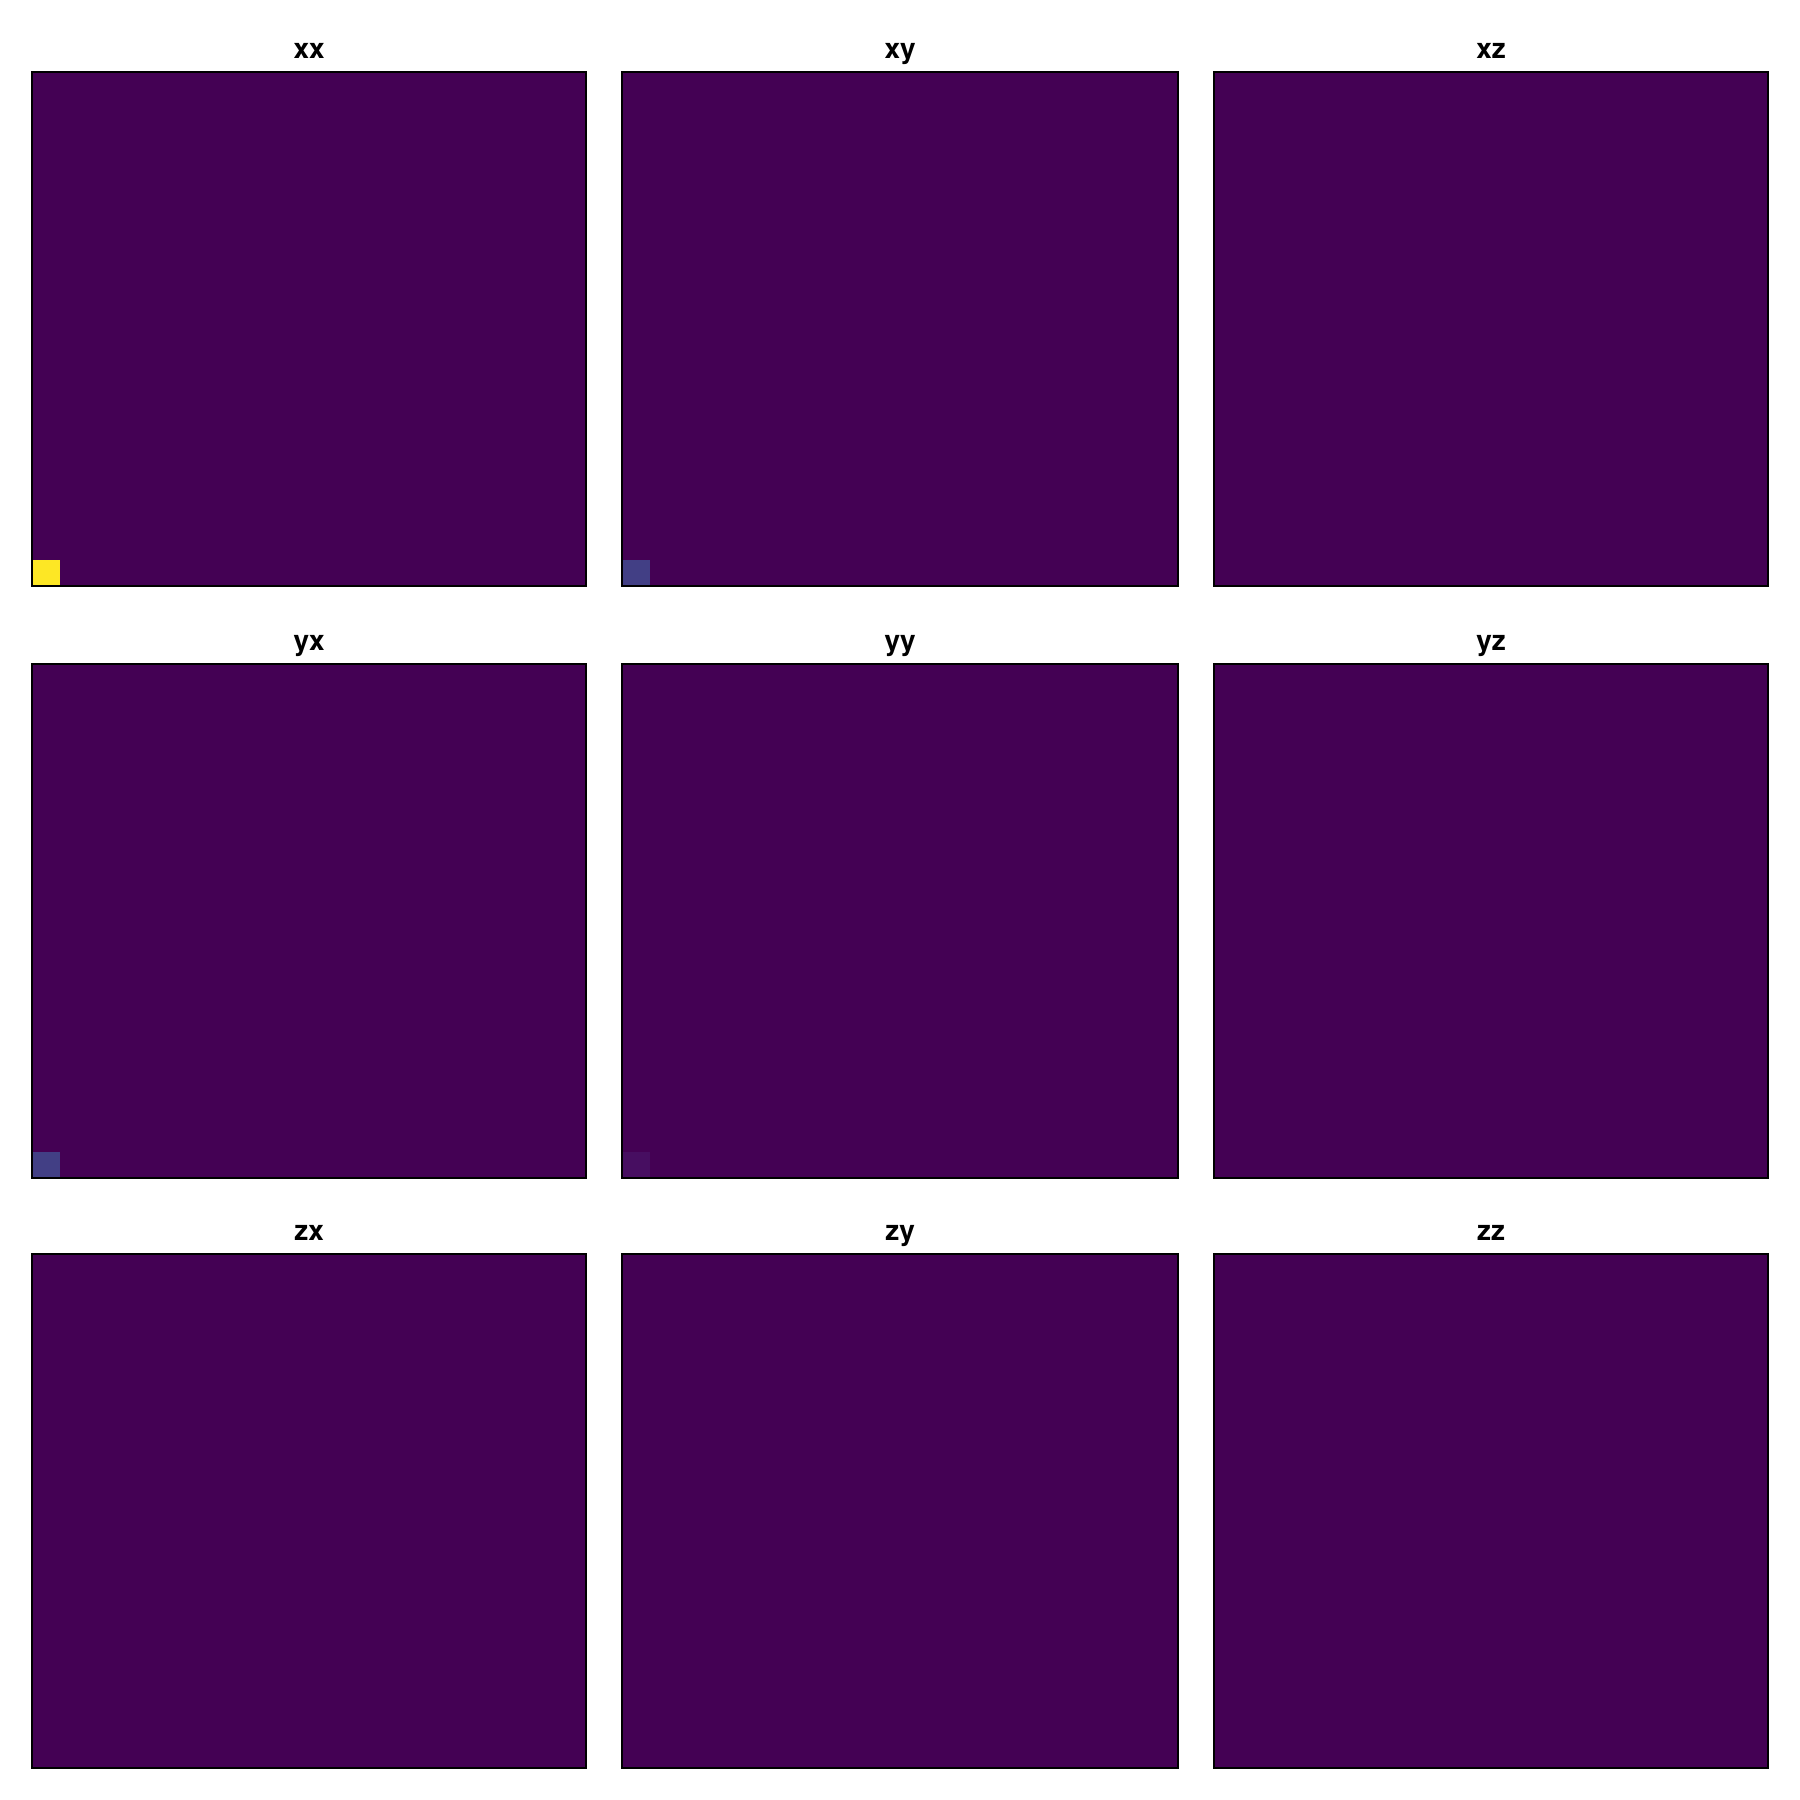

In [82]:
CairoMakie.activate!()

i = 1
Lx = 40
etak_corrs = eta_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

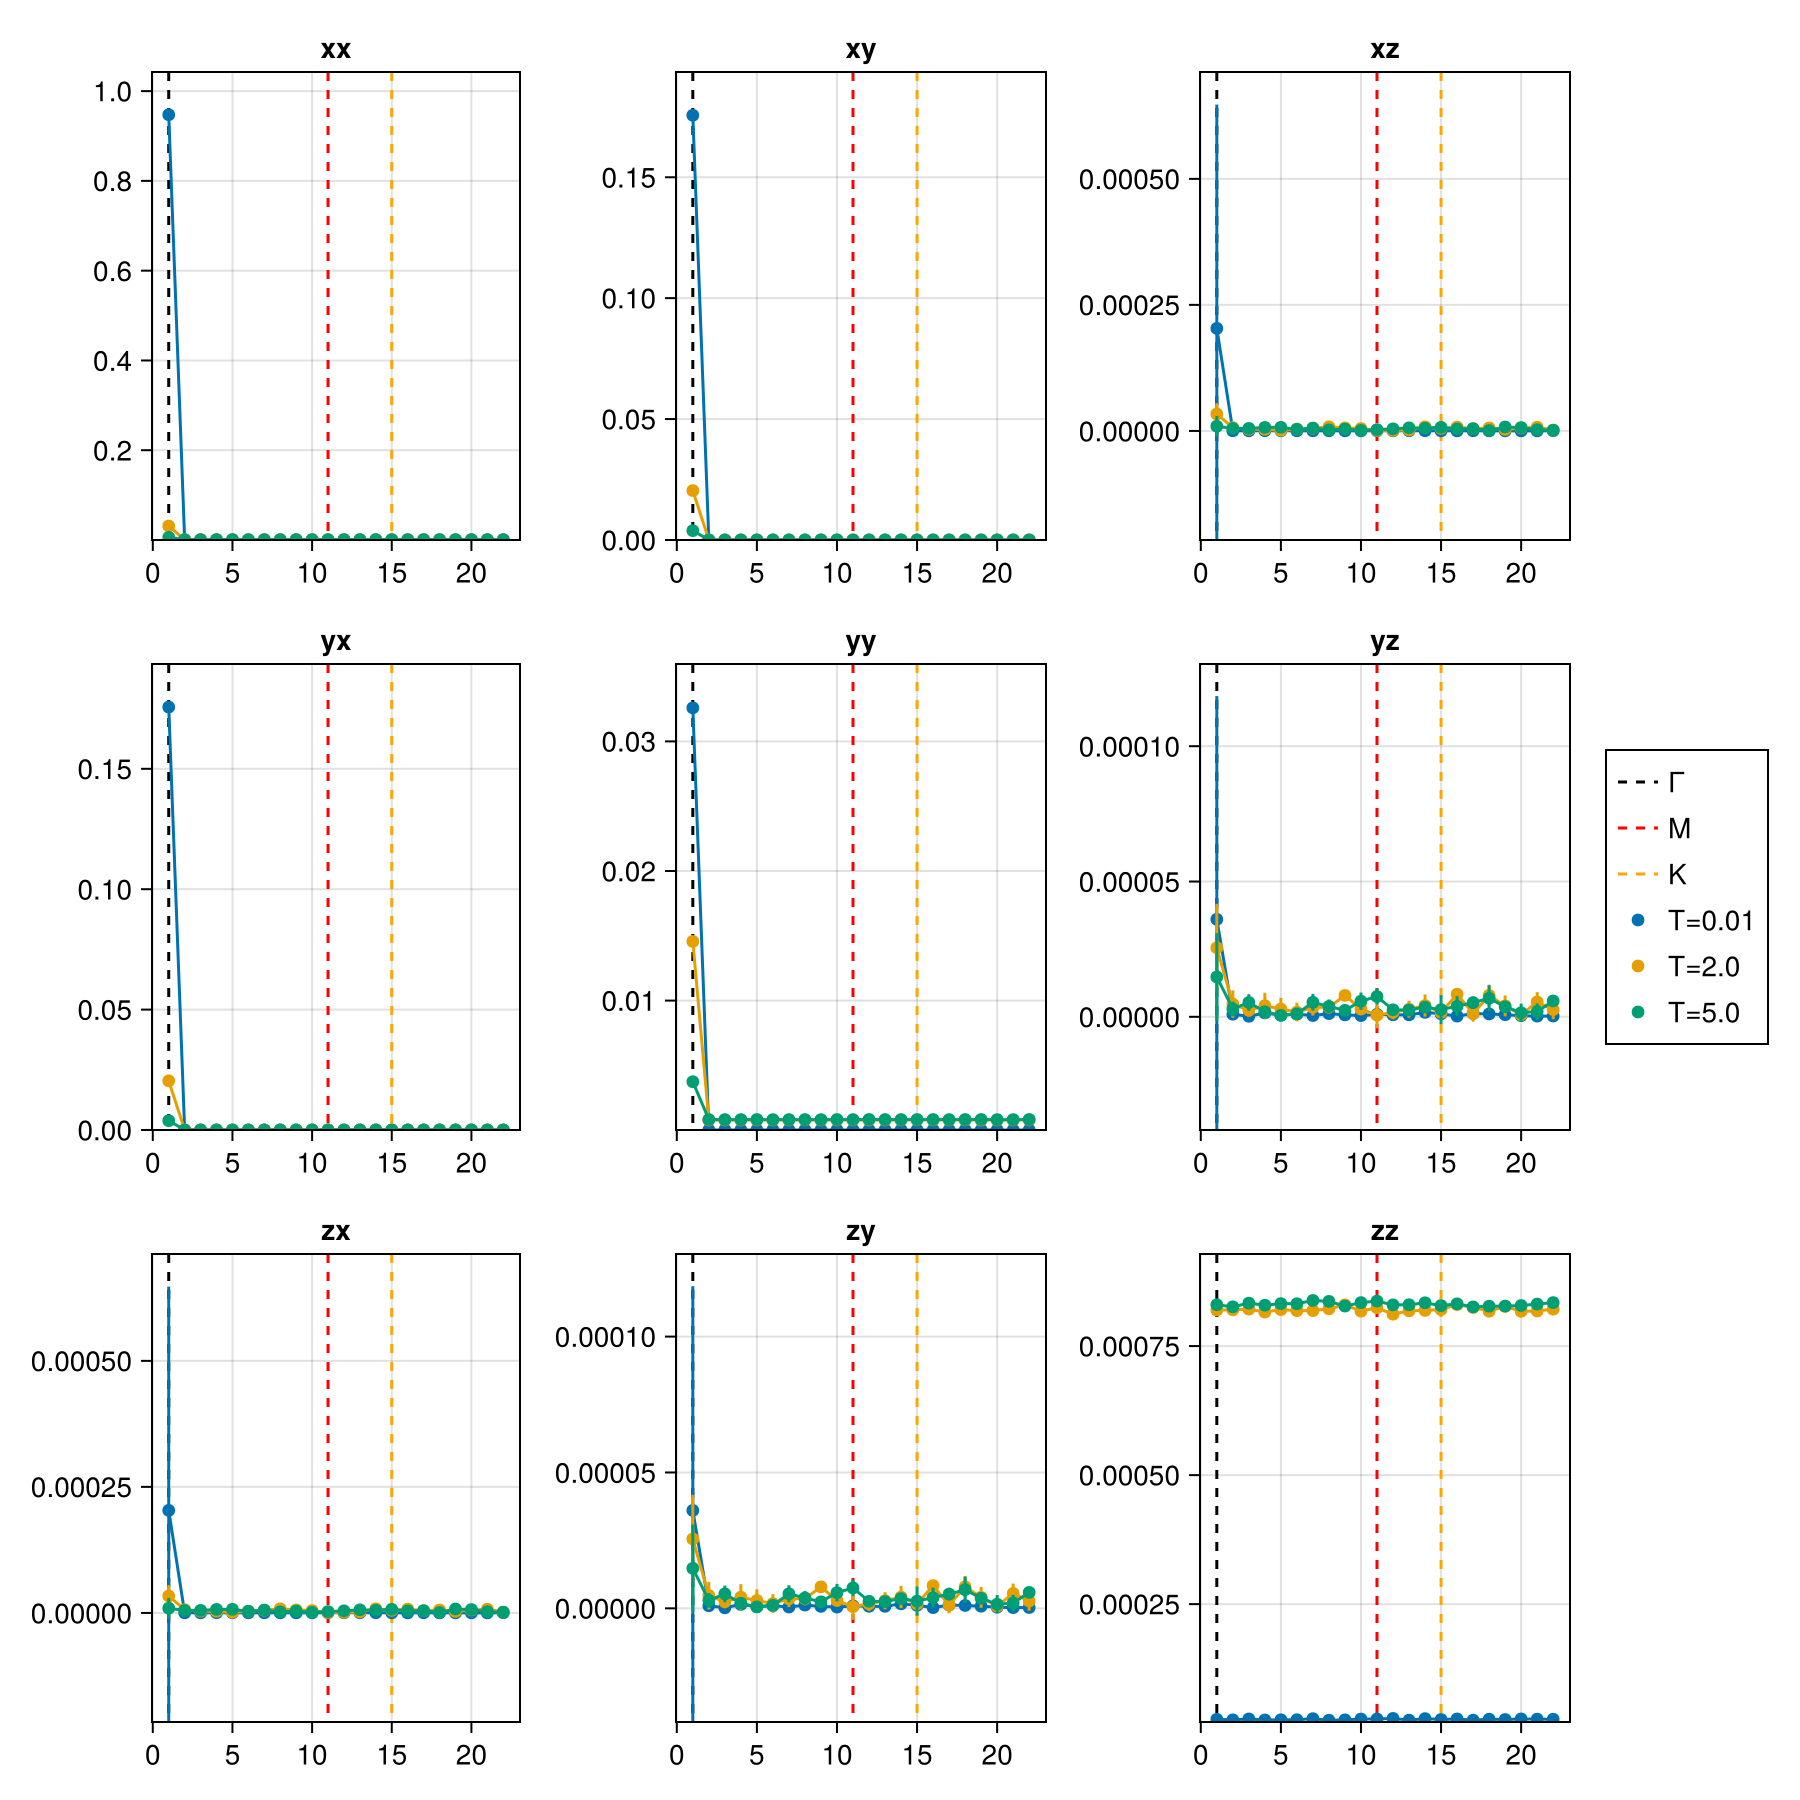

In [83]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = eta_results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 11]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = eta_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig